In [14]:
import sys
sys.path.insert(0, '..')
from lineage import graphs, similarity
import pandas as pd
import os
import networkx as nx
from latex_plots import set_size

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
#RESULT_DIR = '/home/suhail/Projects/relic/primitives/python/generator/dataset_flat_exact/'
RESULT_DIR = '/home/suhail/Projects/sample_workflows/relic_datasets_vldb_2021/dataset_flat_exact/'

notebooks = [d for d in os.listdir(RESULT_DIR) if os.path.isdir(os.path.join(RESULT_DIR, d))]


In [17]:
# Figure settings:

text_width = 506.295
column_width = 241.14749
golden_ratio = (5**.5 - 1) / 2

In [18]:
def load_result_graph_statistics(result_dir, nb, metric):
    g_truth = graphs.get_graph(RESULT_DIR, nb).to_undirected()
    g_infered = graphs.get_graph_edge_list(RESULT_DIR, nb, metric)
    
    edges_data = []
    
    for src,dst,e_data in g_infered.edges(data=True):
        edge_result = {}
        edge_result['src'] = src
        edge_result['dest'] = dst
        edge_result['notebook'] = nb
        edge_result['metric'] = metric
        edge_result['g_truth'] = g_truth.has_edge(src,dst)
        edge_result['type'] = e_data['type']
        edge_result['weight'] = e_data['weight']
        if g_truth.has_edge(src,dst):
            edge_result['operation'] = g_truth[src][dst]['operation']
            
        edges_data.append(edge_result)
        
    return pd.DataFrame(edges_data)
    
    
def ground_truth_edges(result_dir, nb, metric):
    g_truth = graphs.get_graph(RESULT_DIR, nb).to_undirected()
    g_infered = graphs.get_graph_edge_list(RESULT_DIR, nb, metric)
    
    edges_data = []
    
    for src,dst,e_data in g_truth.edges(data=True):
        edge_result = {}
        edge_result['src'] = src
        edge_result['dest'] = dst
        edge_result['notebook'] = nb
        edge_result['metric'] = metric
        edge_result['g_inferred'] = g_infered.has_edge(src,dst)
        edge_result['operation'] = e_data['operation']
        if g_infered.has_edge(src,dst):
            edge_result['type'] = g_infered[src][dst]['type']
            edge_result['weight'] = g_infered[src][dst]['weight']
            
            
        edges_data.append(edge_result)
        
    return pd.DataFrame(edges_data)

def edge_cat(truth, inferred):
    return_str = ''
    if truth and inferred:
        return_str = 'TP'
    elif truth and not inferred:
        return_str = 'FN'
    elif not truth and inferred:
        return_str = 'FP'
    else:
        return_str += 'TN'
        
    return return_str


def get_stage_graph(nb,metric):
    g = nx.read_gpickle(RESULT_DIR+'/'+nb+'/inferred/'+metric+'_stage_graph.pkl')
    return g


def all_edges(result_dir, nb, metric):
    g_truth = graphs.get_graph(RESULT_DIR, nb).to_undirected()
    g_infered = graphs.get_graph_edge_list(RESULT_DIR, nb, metric)
    stage_graph = get_stage_graph(nb,metric)
    
    edges_data = []
    
    all_pw_jaccard_graph = nx.read_gpickle(result_dir+nb+'/inferred/cell_sim.pkl')
        
    for src,dst in all_pw_jaccard_graph.edges():
        #print(nb,src,dst)
        edge_result = {}
        edge_result['src'] = src
        edge_result['dest'] = dst
        edge_result['notebook'] = nb
        edge_result['metric'] = metric
        edge_result['g_inferred'] = g_infered.has_edge(src,dst)
        if g_infered.has_edge(src,dst):
            edge_result['type'] = g_infered[src][dst]['type']
            edge_result['weight'] = g_infered[src][dst]['weight']
        edge_result['g_truth'] = g_truth.has_edge(src,dst)
        if g_truth.has_edge(src,dst):
            edge_result['operation'] = g_truth[src][dst]['operation']
            
            
        stage_dict = stage_graph[src][dst]
        #edge_result.update(stage_dict)            
        edge_result.update( {k:v for (k,v) in stage_dict.items() if 'stage' in k})            
            
        edges_data.append(edge_result)
        
    return pd.DataFrame(edges_data)

In [19]:
from tqdm.auto import tqdm 

#RESULT_DIR = '/home/suhail/Projects/relic/primitives/python/generator/dataset_flat_exact/'

notebooks = [d for d in os.listdir(RESULT_DIR) if os.path.isdir(os.path.join(RESULT_DIR, d))]

metrics = ['cell', 'cell+group+join+pivot', 'pc2cell+group+join+pivot', 'pc2cell+containment+group+join+pivot', 
        'col']

syn_results = pd.DataFrame()
for nb in tqdm(notebooks):  
    for metric in metrics:
        try:
            syn_results = syn_results.append(all_edges(RESULT_DIR, nb, metric))
        except FileNotFoundError as e:
            print(nb, metric)
            pass

20210126-181148 cell
20210126-181148 cell+group+join+pivot
20210126-181148 pc2cell+group+join+pivot
20210126-181148 pc2cell+containment+group+join+pivot
20210126-181148 col



In [20]:
import pickle

def is_alternate_edge(all_equiv_edges, nb, metric, op, src, dst):
    if all_equiv_edges[metric][nb][op]:
        for gt_edge, alternate_edges in all_equiv_edges[metric][nb][op].items():
            #print(gt_edge, alternate_edges)
            if frozenset((src,dst)) in [frozenset(x) for x in alternate_edges]:
                all_equiv_edges[metric][nb][op].pop(gt_edge, None) # Pop this list of edges to prevent further counting
                return True, gt_edge, all_equiv_edges 
    return False, None, all_equiv_edges


with open('data/dataset_flat_exact.pkl', 'rb') as handle:
    all_equiv_edges = pickle.load(handle)

In [21]:
new_results = syn_results.copy().reset_index(drop=True)
new_results['alt_g_truth'] = new_results['g_truth']
new_results['edge'] = new_results.apply(lambda x: frozenset([x['src'], x['dest']]), axis=1)

import copy 
with open('data/dataset_flat_exact.pkl', 'rb') as handle:
    all_equiv_edges = pickle.load(handle)

all_metric_equiv_edges = {}
for metric in metrics:
    all_metric_equiv_edges[metric] = copy.deepcopy(all_equiv_edges)
    
all_metric_equiv_edges

for i, (ix, row) in tqdm(enumerate(new_results.iterrows()), total=len(new_results.index)):
    nb = row['notebook']
    src = row['src']
    dst = row['dest']
    op = row['operation']
    edge_type = row['type']
    metric = row['metric']
    
    if edge_type in ['groupby', 'pivot'] and row['g_inferred'] == True and row['g_truth'] == False:
        is_alt_edge, g_truth_edge, all_metric_equiv_edges = is_alternate_edge(all_metric_equiv_edges, nb, metric, edge_type, src, dst)
        #print(nb, src, dst, is_alt_edge, g_truth_edge)
        #break
        if is_alt_edge:
            print(nb, metric, src, dst, edge_type)
            #break
            # Find g_truth and invalidate
            row = new_results.loc[(new_results.notebook == nb) &
                            (new_results.metric == metric) &
                            (new_results.edge == frozenset([src, dst]))]
            if(row.shape[0] == 1):
                print('changing')
                new_results.loc[(new_results.notebook == nb) &
                            (new_results.metric == metric) &
                            (new_results.edge == frozenset([src, dst])), 'alt_g_truth'] = False
                new_results.at[ix, 'alt_g_truth'] = True
            else:
                print('Too many GT matches!')
                print(row)
                break

20210126-160823 cell+group+join+pivot 13.csv 10.csv pivot
changing
20210126-160823 cell+group+join+pivot 6.csv 14.csv pivot
changing
20210126-160823 pc2cell+group+join+pivot 13.csv 10.csv pivot
changing
20210126-160823 pc2cell+group+join+pivot 6.csv 14.csv pivot
changing
20210126-160823 pc2cell+containment+group+join+pivot 13.csv 10.csv pivot
changing
20210126-160823 pc2cell+containment+group+join+pivot 6.csv 14.csv pivot
changing
20210126-181616 cell+group+join+pivot 5.csv 3.csv groupby
changing
20210126-181616 pc2cell+group+join+pivot 5.csv 3.csv groupby
changing
20210126-181616 pc2cell+containment+group+join+pivot 5.csv 3.csv groupby
changing
20210126-164212 cell+group+join+pivot 4.csv 12.csv groupby
changing
20210126-164212 pc2cell+group+join+pivot 4.csv 12.csv groupby
changing
20210126-164212 pc2cell+containment+group+join+pivot 4.csv 12.csv groupby
changing
20210126-155943 cell+group+join+pivot 8.csv 11.csv pivot
changing
20210126-155943 cell+group+join+pivot 2.csv 11.csv pivot
c

20210126-161913 cell+group+join+pivot 2.csv 10.csv pivot
changing
20210126-161913 pc2cell+group+join+pivot 2.csv 10.csv pivot
changing
20210126-161913 pc2cell+containment+group+join+pivot 2.csv 10.csv pivot
changing
20210126-161013 cell+group+join+pivot 13.csv 18.csv pivot
changing
20210126-161013 cell+group+join+pivot 4.csv 0.csv groupby
changing
20210126-161013 pc2cell+group+join+pivot 13.csv 18.csv pivot
changing
20210126-161013 pc2cell+group+join+pivot 4.csv 0.csv groupby
changing
20210126-161013 pc2cell+containment+group+join+pivot 13.csv 18.csv pivot
changing
20210126-161013 pc2cell+containment+group+join+pivot 4.csv 0.csv groupby
changing
20210126-170140 cell+group+join+pivot 7.csv 3.csv pivot
changing
20210126-170140 pc2cell+group+join+pivot 7.csv 3.csv pivot
changing
20210126-195950 cell+group+join+pivot 41.csv 37.csv pivot
changing
20210126-195950 pc2cell+group+join+pivot 41.csv 37.csv pivot
changing
20210126-195950 pc2cell+containment+group+join+pivot 41.csv 37.csv pivot
cha

20210126-182123 pc2cell+containment+group+join+pivot 9.csv 6.csv pivot
changing
20210126-182123 pc2cell+containment+group+join+pivot 37.csv 14.csv pivot
changing
20210126-182123 pc2cell+containment+group+join+pivot 44.csv 46.csv pivot
changing
20210126-182123 pc2cell+containment+group+join+pivot 8.csv 11.csv pivot
changing
20210126-182123 pc2cell+containment+group+join+pivot 24.csv 45.csv pivot
changing
20210126-183004 cell+group+join+pivot 9.csv 0.csv groupby
changing
20210126-183004 cell+group+join+pivot 40.csv 46.csv groupby
changing
20210126-183004 cell+group+join+pivot 48.csv 45.csv pivot
changing
20210126-183004 pc2cell+group+join+pivot 9.csv 0.csv groupby
changing
20210126-183004 pc2cell+group+join+pivot 40.csv 46.csv groupby
changing
20210126-183004 pc2cell+group+join+pivot 48.csv 45.csv pivot
changing
20210126-183004 pc2cell+containment+group+join+pivot 9.csv 0.csv groupby
changing
20210126-183004 pc2cell+containment+group+join+pivot 40.csv 46.csv groupby
changing
20210126-183

changing
20210126-180914 pc2cell+group+join+pivot 9.csv 8.csv pivot
changing
20210126-180914 pc2cell+group+join+pivot 2.csv 6.csv groupby
changing
20210126-180914 pc2cell+containment+group+join+pivot 9.csv 8.csv pivot
changing
20210126-180914 pc2cell+containment+group+join+pivot 2.csv 6.csv groupby
changing
20210126-155620 cell+group+join+pivot 9.csv 11.csv groupby
changing
20210126-155620 pc2cell+group+join+pivot 9.csv 11.csv groupby
changing
20210126-155620 pc2cell+containment+group+join+pivot 9.csv 11.csv groupby
changing
20210126-171144 cell+group+join+pivot 29.csv 20.csv pivot
changing
20210126-171144 cell+group+join+pivot 16.csv 12.csv pivot
changing
20210126-171144 cell+group+join+pivot 45.csv 35.csv pivot
changing
20210126-171144 pc2cell+group+join+pivot 29.csv 20.csv pivot
changing
20210126-171144 pc2cell+group+join+pivot 16.csv 12.csv pivot
changing
20210126-171144 pc2cell+group+join+pivot 45.csv 35.csv pivot
changing
20210126-171144 pc2cell+containment+group+join+pivot 29.cs

20210126-184058 cell+group+join+pivot 8.csv 0.csv pivot
changing
20210126-184058 cell+group+join+pivot 17.csv 5.csv pivot
changing
20210126-184058 cell+group+join+pivot 32.csv 11.csv pivot
changing
20210126-184058 pc2cell+group+join+pivot 7.csv 22.csv pivot
changing
20210126-184058 pc2cell+group+join+pivot 23.csv 5.csv pivot
changing
20210126-184058 pc2cell+group+join+pivot 8.csv 0.csv pivot
changing
20210126-184058 pc2cell+group+join+pivot 17.csv 5.csv pivot
changing
20210126-184058 pc2cell+group+join+pivot 32.csv 11.csv pivot
changing
20210126-184058 pc2cell+containment+group+join+pivot 7.csv 22.csv pivot
changing
20210126-184058 pc2cell+containment+group+join+pivot 23.csv 5.csv pivot
changing
20210126-184058 pc2cell+containment+group+join+pivot 8.csv 0.csv pivot
changing
20210126-184058 pc2cell+containment+group+join+pivot 17.csv 5.csv pivot
changing
20210126-184058 pc2cell+containment+group+join+pivot 32.csv 11.csv pivot
changing
20210126-163615 cell+group+join+pivot 8.csv 0.csv pi

changing
20210126-160843 pc2cell+containment+group+join+pivot 9.csv 0.csv groupby
changing
20210126-160843 pc2cell+containment+group+join+pivot 14.csv 4.csv groupby
changing
20210126-181925 cell+group+join+pivot 13.csv 8.csv pivot
changing
20210126-181925 cell+group+join+pivot 18.csv 48.csv pivot
changing
20210126-181925 cell+group+join+pivot 30.csv 25.csv pivot
changing
20210126-181925 cell+group+join+pivot 5.csv 12.csv pivot
changing
20210126-181925 pc2cell+group+join+pivot 13.csv 8.csv pivot
changing
20210126-181925 pc2cell+group+join+pivot 18.csv 48.csv pivot
changing
20210126-181925 pc2cell+group+join+pivot 30.csv 25.csv pivot
changing
20210126-181925 pc2cell+group+join+pivot 5.csv 12.csv pivot
changing
20210126-181925 pc2cell+containment+group+join+pivot 13.csv 8.csv pivot
changing
20210126-181925 pc2cell+containment+group+join+pivot 18.csv 48.csv pivot
changing
20210126-181925 pc2cell+containment+group+join+pivot 30.csv 25.csv pivot
changing
20210126-181925 pc2cell+containment+g

20210126-171218 pc2cell+group+join+pivot 5.csv 12.csv groupby
changing
20210126-171218 pc2cell+containment+group+join+pivot 18.csv 38.csv pivot
changing
20210126-171218 pc2cell+containment+group+join+pivot 27.csv 32.csv pivot
changing
20210126-171218 pc2cell+containment+group+join+pivot 5.csv 12.csv groupby
changing
20210126-181514 cell+group+join+pivot 33.csv 30.csv groupby
changing
20210126-181514 pc2cell+group+join+pivot 33.csv 30.csv groupby
changing
20210126-181514 pc2cell+containment+group+join+pivot 33.csv 30.csv groupby
changing
20210126-181405 cell+group+join+pivot 2.csv 10.csv groupby
changing
20210126-181405 pc2cell+group+join+pivot 2.csv 10.csv groupby
changing
20210126-181405 pc2cell+containment+group+join+pivot 2.csv 10.csv groupby
changing
20210126-181326 cell+group+join+pivot 31.csv 33.csv pivot
changing
20210126-181326 cell+group+join+pivot 19.csv 24.csv groupby
changing
20210126-181326 pc2cell+group+join+pivot 31.csv 33.csv pivot
changing
20210126-181326 pc2cell+group

In [22]:
new_results.loc[new_results.alt_g_truth != new_results.g_truth]

,src,dest,notebook,metric,g_inferred,type,weight,g_truth,operation,stage_0,...,stage_1_intra1_weight,stage_1_intra1_op,stage_1_intra2,stage_1_intra2_weight,stage_1_intra2_op,stage_5_pivot,stage_5_pivot_weight,stage_5_pivot_op,alt_g_truth,edge
1156,13.csv,10.csv,20210126-160823,cell+group+join+pivot,True,pivot,1.0,False,NaN,input,...,NaN,NaN,NaN,NaN,NaN,considered,1.0,selected,True,"(10.csv, 13.csv)"
1275,6.csv,14.csv,20210126-160823,cell+group+join+pivot,True,pivot,1.0,False,NaN,input,...,NaN,NaN,NaN,NaN,NaN,considered,1.0,selected,True,"(14.csv, 6.csv)"
1346,13.csv,10.csv,20210126-160823,pc2cell+group+join+pivot,True,pivot,1.0,False,NaN,input,...,NaN,NaN,NaN,NaN,NaN,considered,1.0,selected,True,"(10.csv, 13.csv)"
1465,6.csv,14.csv,20210126-160823,pc2cell+group+join+pivot,True,pivot,1.0,False,NaN,input,...,NaN,NaN,NaN,NaN,NaN,considered,1.0,NaN,True,"(14.csv, 6.csv)"
1536,13.csv,10.csv,20210126-160823,pc2cell+containment+group+join+pivot,True,pivot,1.0,False,NaN,input,...,NaN,NaN,NaN,NaN,NaN,considered,1.0,NaN,True,"(10.csv, 13.csv)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694717,7.csv,3.csv,20210126-171247,cell+group+join+pivot,True,pivot,1.0,False,NaN,input,...,NaN,NaN,NaN,NaN,NaN,considered,1.0,NaN,True,"(7.csv, 3.csv)"
695212,33.csv,30.csv,20210126-171247,cell+group+join+pivot,True,groupby,1.0,False,NaN,input,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,"(33.csv, 30.csv)"
695942,7.csv,3.csv,20210126-171247,pc2cell+group+join+pivot,True,pivot,1.0,False,NaN,input,...,NaN,NaN,NaN,NaN,NaN,considered,1.0,selected,True,"(7.csv, 3.csv)"
696437,33.csv,30.csv,20210126-171247,pc2cell+group+join+pivot,True,groupby,1.0,False,NaN,input,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,"(33.csv, 30.csv)"


In [55]:
new_results.loc[(new_results.metric == 'pc2cell+containment+group+join+pivot') & (new_results.alt_g_truth != new_results.g_truth)]

,src,dest,notebook,metric,g_inferred,type,weight,g_truth,operation,stage_0,...,stage_1_intra1_weight,stage_1_intra1_op,stage_1_intra2,stage_1_intra2_weight,stage_1_intra2_op,stage_5_pivot,stage_5_pivot_weight,stage_5_pivot_op,alt_g_truth,edge
1536,13.csv,10.csv,20210126-160823,pc2cell+containment+group+join+pivot,True,pivot,1.00,False,NaN,input,...,NaN,NaN,NaN,NaN,NaN,considered,1.0,NaN,True,"(10.csv, 13.csv)"
1655,6.csv,14.csv,20210126-160823,pc2cell+containment+group+join+pivot,True,pivot,1.00,False,NaN,input,...,NaN,NaN,NaN,NaN,NaN,considered,1.0,selected,True,"(14.csv, 6.csv)"
6627,5.csv,3.csv,20210126-181616,pc2cell+containment+group+join+pivot,True,groupby,0.75,False,NaN,input,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,"(3.csv, 5.csv)"
8771,4.csv,12.csv,20210126-164212,pc2cell+containment+group+join+pivot,True,groupby,1.00,False,NaN,input,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,"(4.csv, 12.csv)"
9623,8.csv,11.csv,20210126-155943,pc2cell+containment+group+join+pivot,True,pivot,1.00,False,NaN,input,...,NaN,NaN,NaN,NaN,NaN,considered,1.0,selected,True,"(8.csv, 11.csv)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684941,16.csv,1.csv,20210126-181734,pc2cell+containment+group+join+pivot,True,groupby,0.75,False,NaN,input,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,"(16.csv, 1.csv)"
686925,8.csv,0.csv,20210126-160531,pc2cell+containment+group+join+pivot,True,pivot,1.00,False,NaN,input,...,NaN,NaN,NaN,NaN,NaN,considered,1.0,NaN,True,"(8.csv, 0.csv)"
691482,8.csv,0.csv,20210126-173547,pc2cell+containment+group+join+pivot,True,pivot,1.00,False,NaN,input,...,NaN,NaN,NaN,NaN,NaN,considered,1.0,NaN,True,"(8.csv, 0.csv)"
691616,18.csv,0.csv,20210126-173547,pc2cell+containment+group+join+pivot,True,pivot,1.00,False,NaN,input,...,NaN,NaN,NaN,NaN,NaN,considered,1.0,selected,True,"(18.csv, 0.csv)"


In [23]:
def compute_nb_metrics(df, nb, metric, g_truth_col, g_inferred_col):
    try:
        TP = df.loc[(df.notebook == nb) &
                             (df.metric == metric) &
                             (df[g_truth_col] == True) &
                             (df[g_inferred_col] == True)
                            ].iloc[0]['count']
    except IndexError as e:
        TP = 0

    try:
        FP = df.loc[(df.notebook == nb) &
                             (df.metric == metric) &
                             (df[g_truth_col] == False) &
                             (df[g_inferred_col] == True)
                            ].iloc[0]['count']
    except IndexError as e:
        FP = 0
    
    try:
        FN = df.loc[(df.notebook == nb) &
                             (df.metric == metric) &
                             (df[g_truth_col] == True) &
                             (df[g_inferred_col] == False)
                            ].iloc[0]['count']
    except IndexError as e:
        FN = 0
        
    #print(TP,FP,FN)
    precision = float(TP) / float(TP+FP)
    recall = float(TP) / float(TP+FN)
    F1 = 2 * ((precision * recall) / (precision + recall))
    return precision, recall, F1

def create_agg_df(results, notebooks, metrics, g_truth_col, g_inferred_col):
    agg_results = []
    for nb in notebooks:
        for metric in metrics:
            p,r,f1 = compute_nb_metrics(results, nb, 
                                        metric, g_truth_col, g_inferred_col)
            agg_results.append({
                'nb': nb,
                'metric': metric,
                'precision': p,
                'recall': r,
                'f1': f1
            })
        
    agg_df = pd.DataFrame(agg_results)
    return agg_df
        

In [24]:
notebooks = set(new_results.notebook.values)
metrics = set(new_results.metric.values)

original_results = new_results.groupby(['notebook','metric','g_truth', 'g_inferred'])['stage_0'].count().reset_index(name="count")
agg_df1 = create_agg_df(original_results, notebooks, metrics, 'g_truth', 'g_inferred')
alt_results = new_results.groupby(['notebook','metric','alt_g_truth', 'g_inferred'])['stage_0'].count().reset_index(name="count")
agg_df2 = create_agg_df(alt_results, notebooks, metrics, 'alt_g_truth', 'g_inferred')

In [25]:
agg_df3 = agg_df1.merge(agg_df2, on=['nb', 'metric'], suffixes=['_old','_new'])
config = pd.read_csv('data/dataset_flat_exact_config.csv', index_col=0).drop_duplicates()
agg_df3 = agg_df3.merge(config, left_on='nb', right_on='nb_name', how='left').sort_values('nb')
agg_df3[['nb', 'artifacts3', 'f1_old', 'f1_new']]
agg_df4= pd.melt(agg_df3, id_vars=['nb','metric','artifacts3'], value_vars=['f1_old', 'f1_new'],
       var_name='f1_type', value_name='f1')
agg_df4

,nb,metric,artifacts3,f1_type,f1
0,20210126-153738,col,"20,100,10",f1_old,0.947368
1,20210126-153738,cell+group+join+pivot,"20,100,10",f1_old,0.864865
2,20210126-153738,pc2cell+containment+group+join+pivot,"20,100,10",f1_old,0.947368
3,20210126-153738,cell,"20,100,10",f1_old,0.842105
4,20210126-153738,pc2cell+group+join+pivot,"20,100,10",f1_old,0.947368
...,...,...,...,...,...
1985,20210126-201524,cell,"50,100000,20",f1_new,0.755102
1986,20210126-201524,cell+group+join+pivot,"50,100000,20",f1_new,0.938776
1987,20210126-201524,pc2cell+group+join+pivot,"50,100000,20",f1_new,0.969697
1988,20210126-201524,col,"50,100000,20",f1_new,0.836735


/tmp/ipykernel_1667670/2323863067.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_df5['metric'] = agg_df5['metric'].replace(metric_rename)


Text(0, 0.5, 'F1 Score')

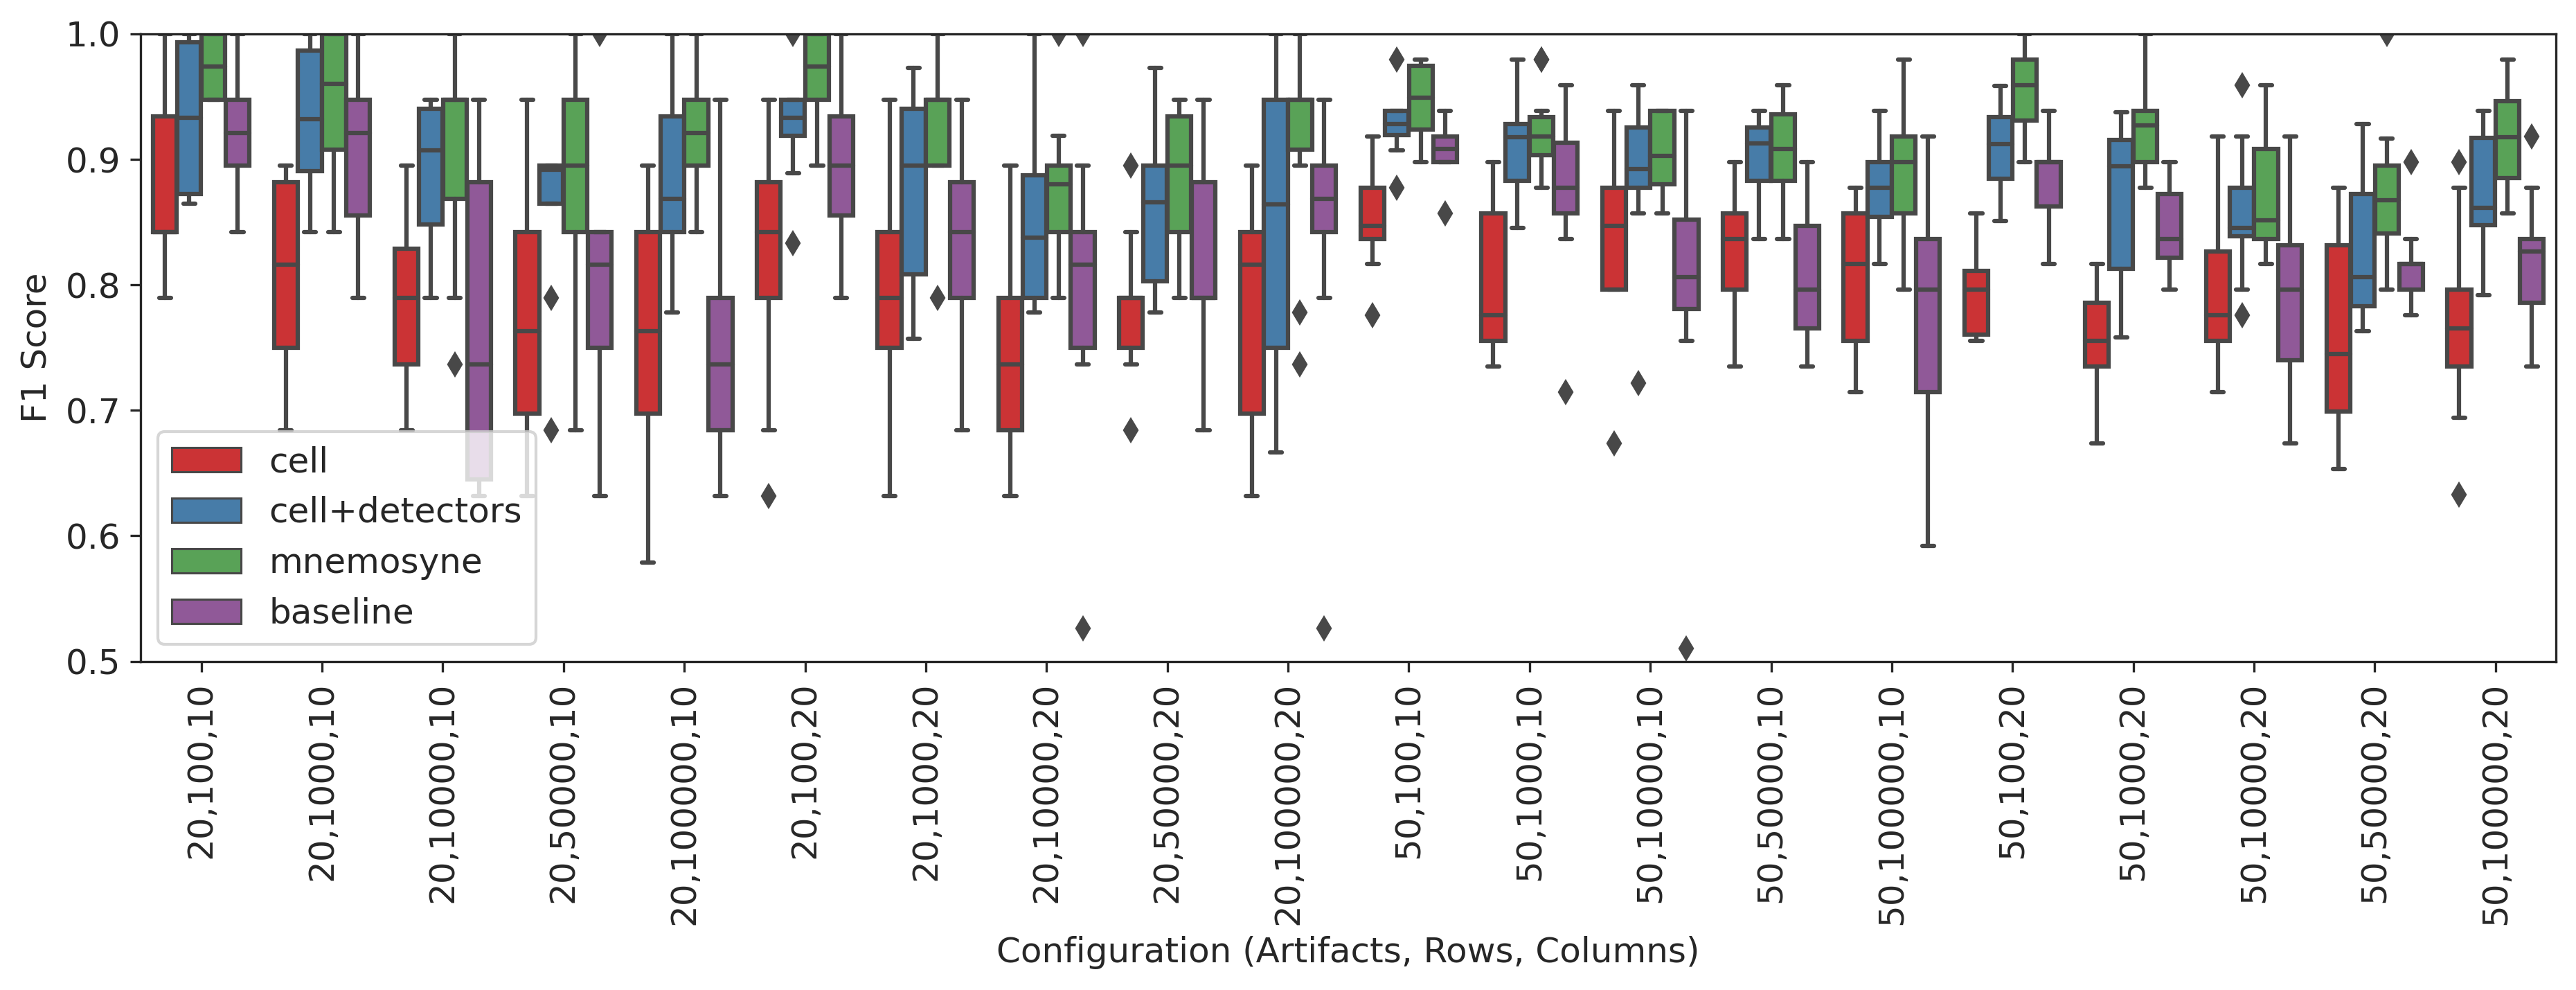

In [45]:
# Totals of Old F1 Score for each config
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(num=None, figsize=(15, 4), dpi=300, facecolor='w', edgecolor='k')
sns.set_style("ticks")

metric_rename = {'cell': 'cell',
 'pc2cell+containment+group+join+pivot': 'mnemosyne',
 'pc2cell+group+join+pivot': 'pc2cell+group+join+pivot',
 'col': 'baseline',
 'cell+group+join+pivot': 'cell+detectors'}

order = ['cell', 'cell+group+join+pivot', 
         'pc2cell+group+join+pivot', 'pc2cell+containment+group+join+pivot','col']


agg_df5 = agg_df4.loc[agg_df4.f1_type == 'f1_old']
agg_df5['metric'] = agg_df5['metric'].replace(metric_rename)

order = ['cell', 'cell+detectors','mnemosyne','baseline']


chart = sns.boxplot(x=agg_df4.artifacts3, y='f1', hue="metric", data=agg_df5, 
                    palette="Set1", hue_order=order)
x_labels = chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
L = plt.legend(loc='best')

plt.ylim(0.5,1.0)
plt.xlabel('Configuration (Artifacts, Rows, Columns)')
plt.ylabel('F1 Score')

In [46]:
#Get a sample for timing
agg_df5[['artifacts', 'rows', 'columns']] = agg_df5.artifacts3.str.split(',', expand=True)
agg_df6 = agg_df5.loc[(agg_df5.f1_type == 'f1_old')  & (agg_df5.rows != '50000')]
#agg_df6 = agg_df5.set_index(['artifacts','columns','rows'])
#[print(x) for x in agg_df6.loc[(agg_df5.metric == 'cell') & (agg_df5.artifacts == '20')].groupby('artifacts3', group_keys=False).apply(lambda x: x.sample(min(len(x), 5)))['nb']]
agg_df6.rows.value_counts()

/home/suhail/anaconda3/envs/relic/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


1000      200
10000     200
100       200
100000    195
Name: rows, dtype: int64

(0.5, 1.0)

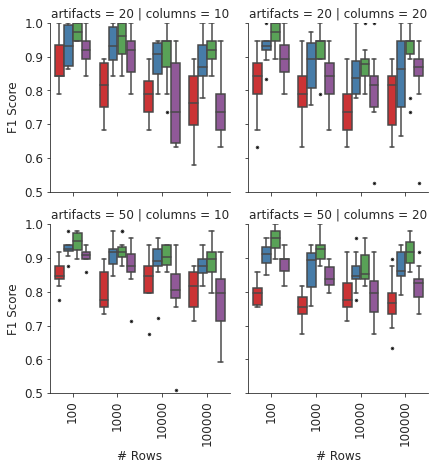

In [47]:
g = sns.FacetGrid(agg_df6, col='columns', row='artifacts')
outlierst = dict(markerfacecolor='black', marker='.')
g.map_dataframe(sns.boxplot, x='rows', y='f1', hue='metric', palette="Set1", hue_order=order, flierprops=outlierst)
labels = [plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
g.set_axis_labels("# Rows", "F1 Score")

plt.ylim(0.5,1.0)


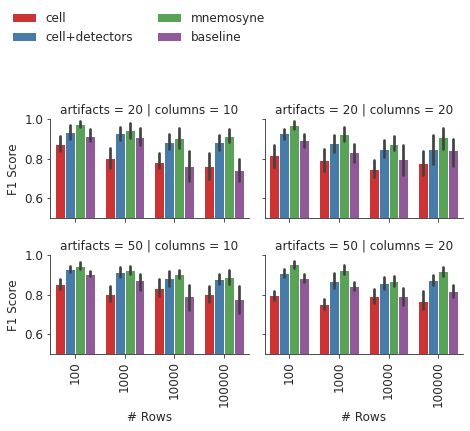

In [48]:
#fig = plt.figure(figsize=set_size(column_width, fraction=0.5))\

w, h = set_size(column_width, subplots=(2,2))
g = sns.FacetGrid(agg_df6, col='columns', row='artifacts', height=h , aspect=1.0/golden_ratio)
outlierst = dict(markerfacecolor='black', marker='.')
g.map_dataframe(sns.barplot, x='rows', y='f1', hue='metric', palette="Set1", hue_order=order)
labels = [plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
g.set_axis_labels("# Rows", "F1 Score")
plt.ylim(0.5,1.0)
g.add_legend(loc='upper center', ncol=2, bbox_to_anchor=(0.2,1.3))

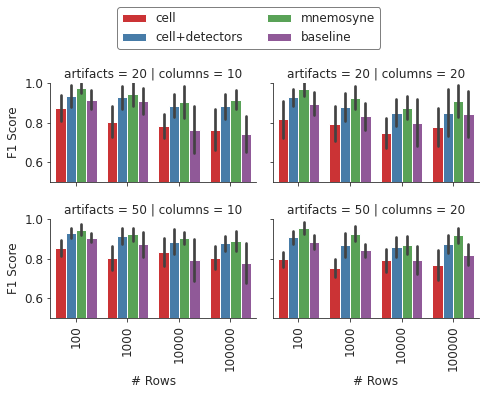

In [49]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

w, h = set_size(column_width, subplots=(2,2))
g = sns.FacetGrid(agg_df6, col='columns', row='artifacts', height=h , aspect=1.0/golden_ratio)

outlierst = dict(markerfacecolor='black', marker='.')
g.map_dataframe(sns.barplot, x='rows', y='f1', hue='metric', palette="Set1", hue_order=order, ci='sd')
labels = [plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
g.set_axis_labels("# Rows", "F1 Score")
plt.ylim(0.5,1.0)
#g.add_legend(loc='best', ncol=2, bbox_to_anchor=(0.55,1.25), mode='expand', label_order=order, fancybox=True)
L = plt.legend(loc='upper right', ncol=2, bbox_to_anchor=(0.55, 3.2), framealpha=1.0, edgecolor='grey')
#g.add_legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
g.fig.savefig('syn-1.pdf', format='pdf', bbox_inches='tight', dpi=300)

In [ ]:
# g = sns.FacetGrid(agg_df6, col='columns', row='artifacts')
outlierst = dict(markerfacecolor='black', marker='.')
g.map_dataframe(sns.barplot, x='rows', y='f1', hue='metric', palette="Set1", hue_order=order, ci=None)
labels = [plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
g.set_axis_labels("# Rows", "F1 Score")
plt.ylim(0.5,1.0)


In [183]:
agg_df5 = agg_df4.loc[agg_df4.metric == 'pc2cell+containment+group+join+pivot']
agg_df5.loc[agg_df5.f1_type == 'f1_old']['f1'].mean()

0.9149000729008399

In [184]:
agg_df5 = agg_df4.loc[agg_df4.metric == 'pc2cell+containment+group+join+pivot']
agg_df5.loc[agg_df5.f1_type == 'f1_new']['f1'].mean()

0.9347739939182128

Text(0, 0.5, 'F1 Score')

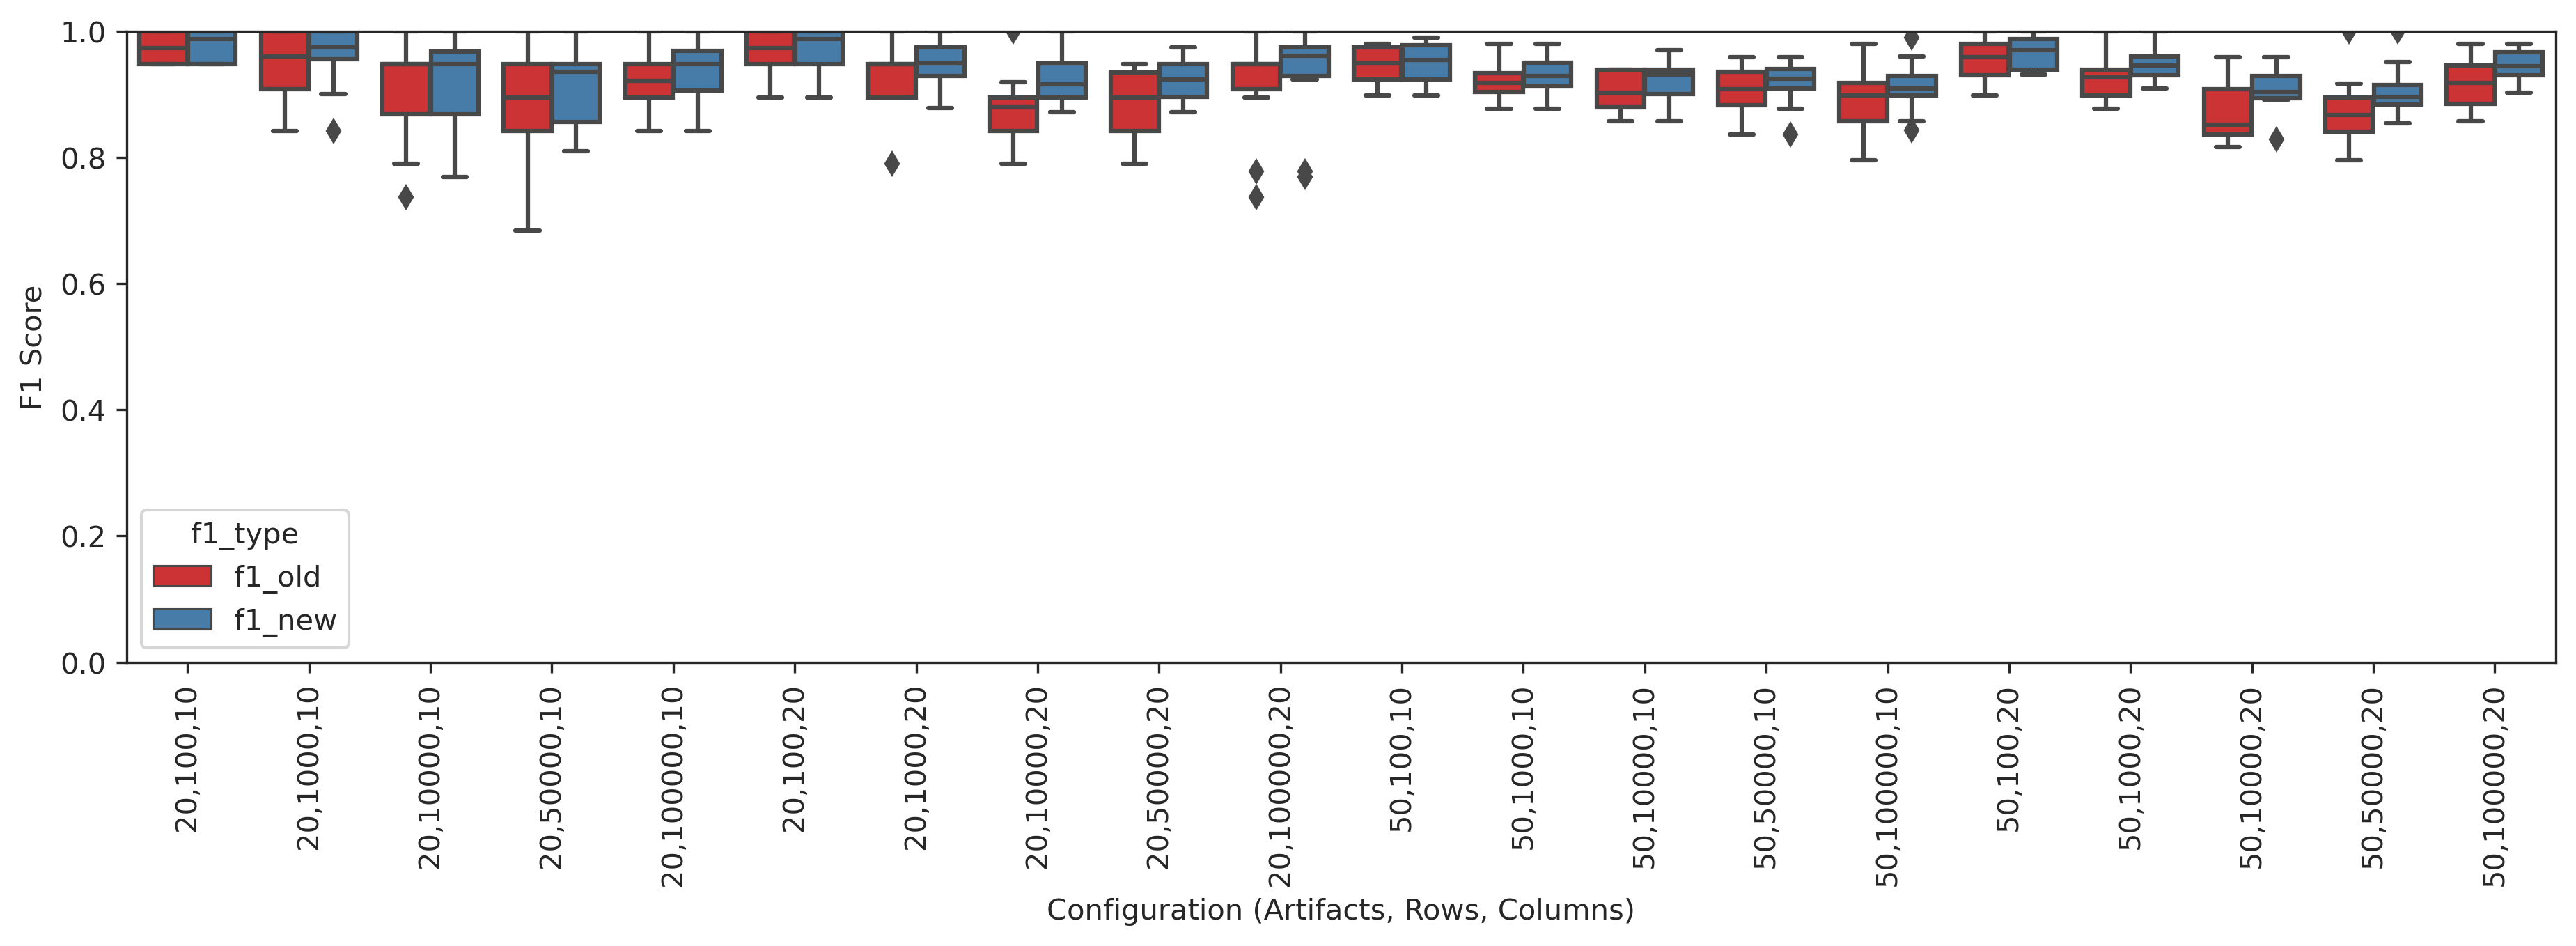

In [174]:
# Comparison of old and new F1 score for our technique
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(num=None, figsize=(15, 4), dpi=300, facecolor='w', edgecolor='k')
sns.set_style("ticks")

order = ['f1_old', 'f1_new']

agg_df5 = agg_df4.loc[agg_df4.metric == 'pc2cell+containment+group+join+pivot']

chart = sns.boxplot(x=agg_df4.artifacts3, y='f1', hue="f1_type", data=agg_df5, 
                    palette="Set1", hue_order=order)
x_labels = chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.ylim(0.0,1.0)
plt.xlabel('Configuration (Artifacts, Rows, Columns)')
plt.ylabel('F1 Score')

# Real Workflow F1 Scores


In [50]:

from tqdm.auto import tqdm 

RESULT_DIR = '/home/suhail/Projects/sample_workflows/million_notebooks/selected_1/'

notebooks = [d for d in os.listdir(RESULT_DIR) if os.path.isdir(os.path.join(RESULT_DIR, d))]

metrics = ['cell', 'cell+group+join+pivot', 'pc2cell+group+join+pivot', 'pc2cell+containment+group+join+pivot', 
        'col']

real_results = pd.DataFrame()
for nb in tqdm(notebooks):  
    for metric in metrics:
        try:
            real_results = real_results.append(all_edges(RESULT_DIR, nb, metric))
        except FileNotFoundError as e:
            print(nb, metric)
            pass

In [51]:
notebooks = set(real_results.notebook.values)
metrics = set(real_results.metric.values)

original_results = real_results.groupby(['notebook','metric','g_truth', 'g_inferred'])['stage_0'].count().reset_index(name="count")
agg_df1 = create_agg_df(original_results, notebooks, metrics, 'g_truth', 'g_inferred').sort_values('nb')
agg_df1

,nb,metric,precision,recall,f1
49,agri-mex,pc2cell+containment+group+join+pivot,1.000000,1.000000,1.000000
45,agri-mex,col,1.000000,1.000000,1.000000
48,agri-mex,cell,0.833333,0.833333,0.833333
47,agri-mex,cell+group+join+pivot,1.000000,0.833333,0.909091
46,agri-mex,pc2cell+group+join+pivot,1.000000,0.833333,0.909091
30,churn,col,0.600000,0.600000,0.600000
32,churn,cell+group+join+pivot,1.000000,0.400000,0.571429
33,churn,cell,0.600000,0.600000,0.600000
31,churn,pc2cell+group+join+pivot,1.000000,0.400000,0.571429
34,churn,pc2cell+containment+group+join+pivot,1.000000,0.400000,0.571429


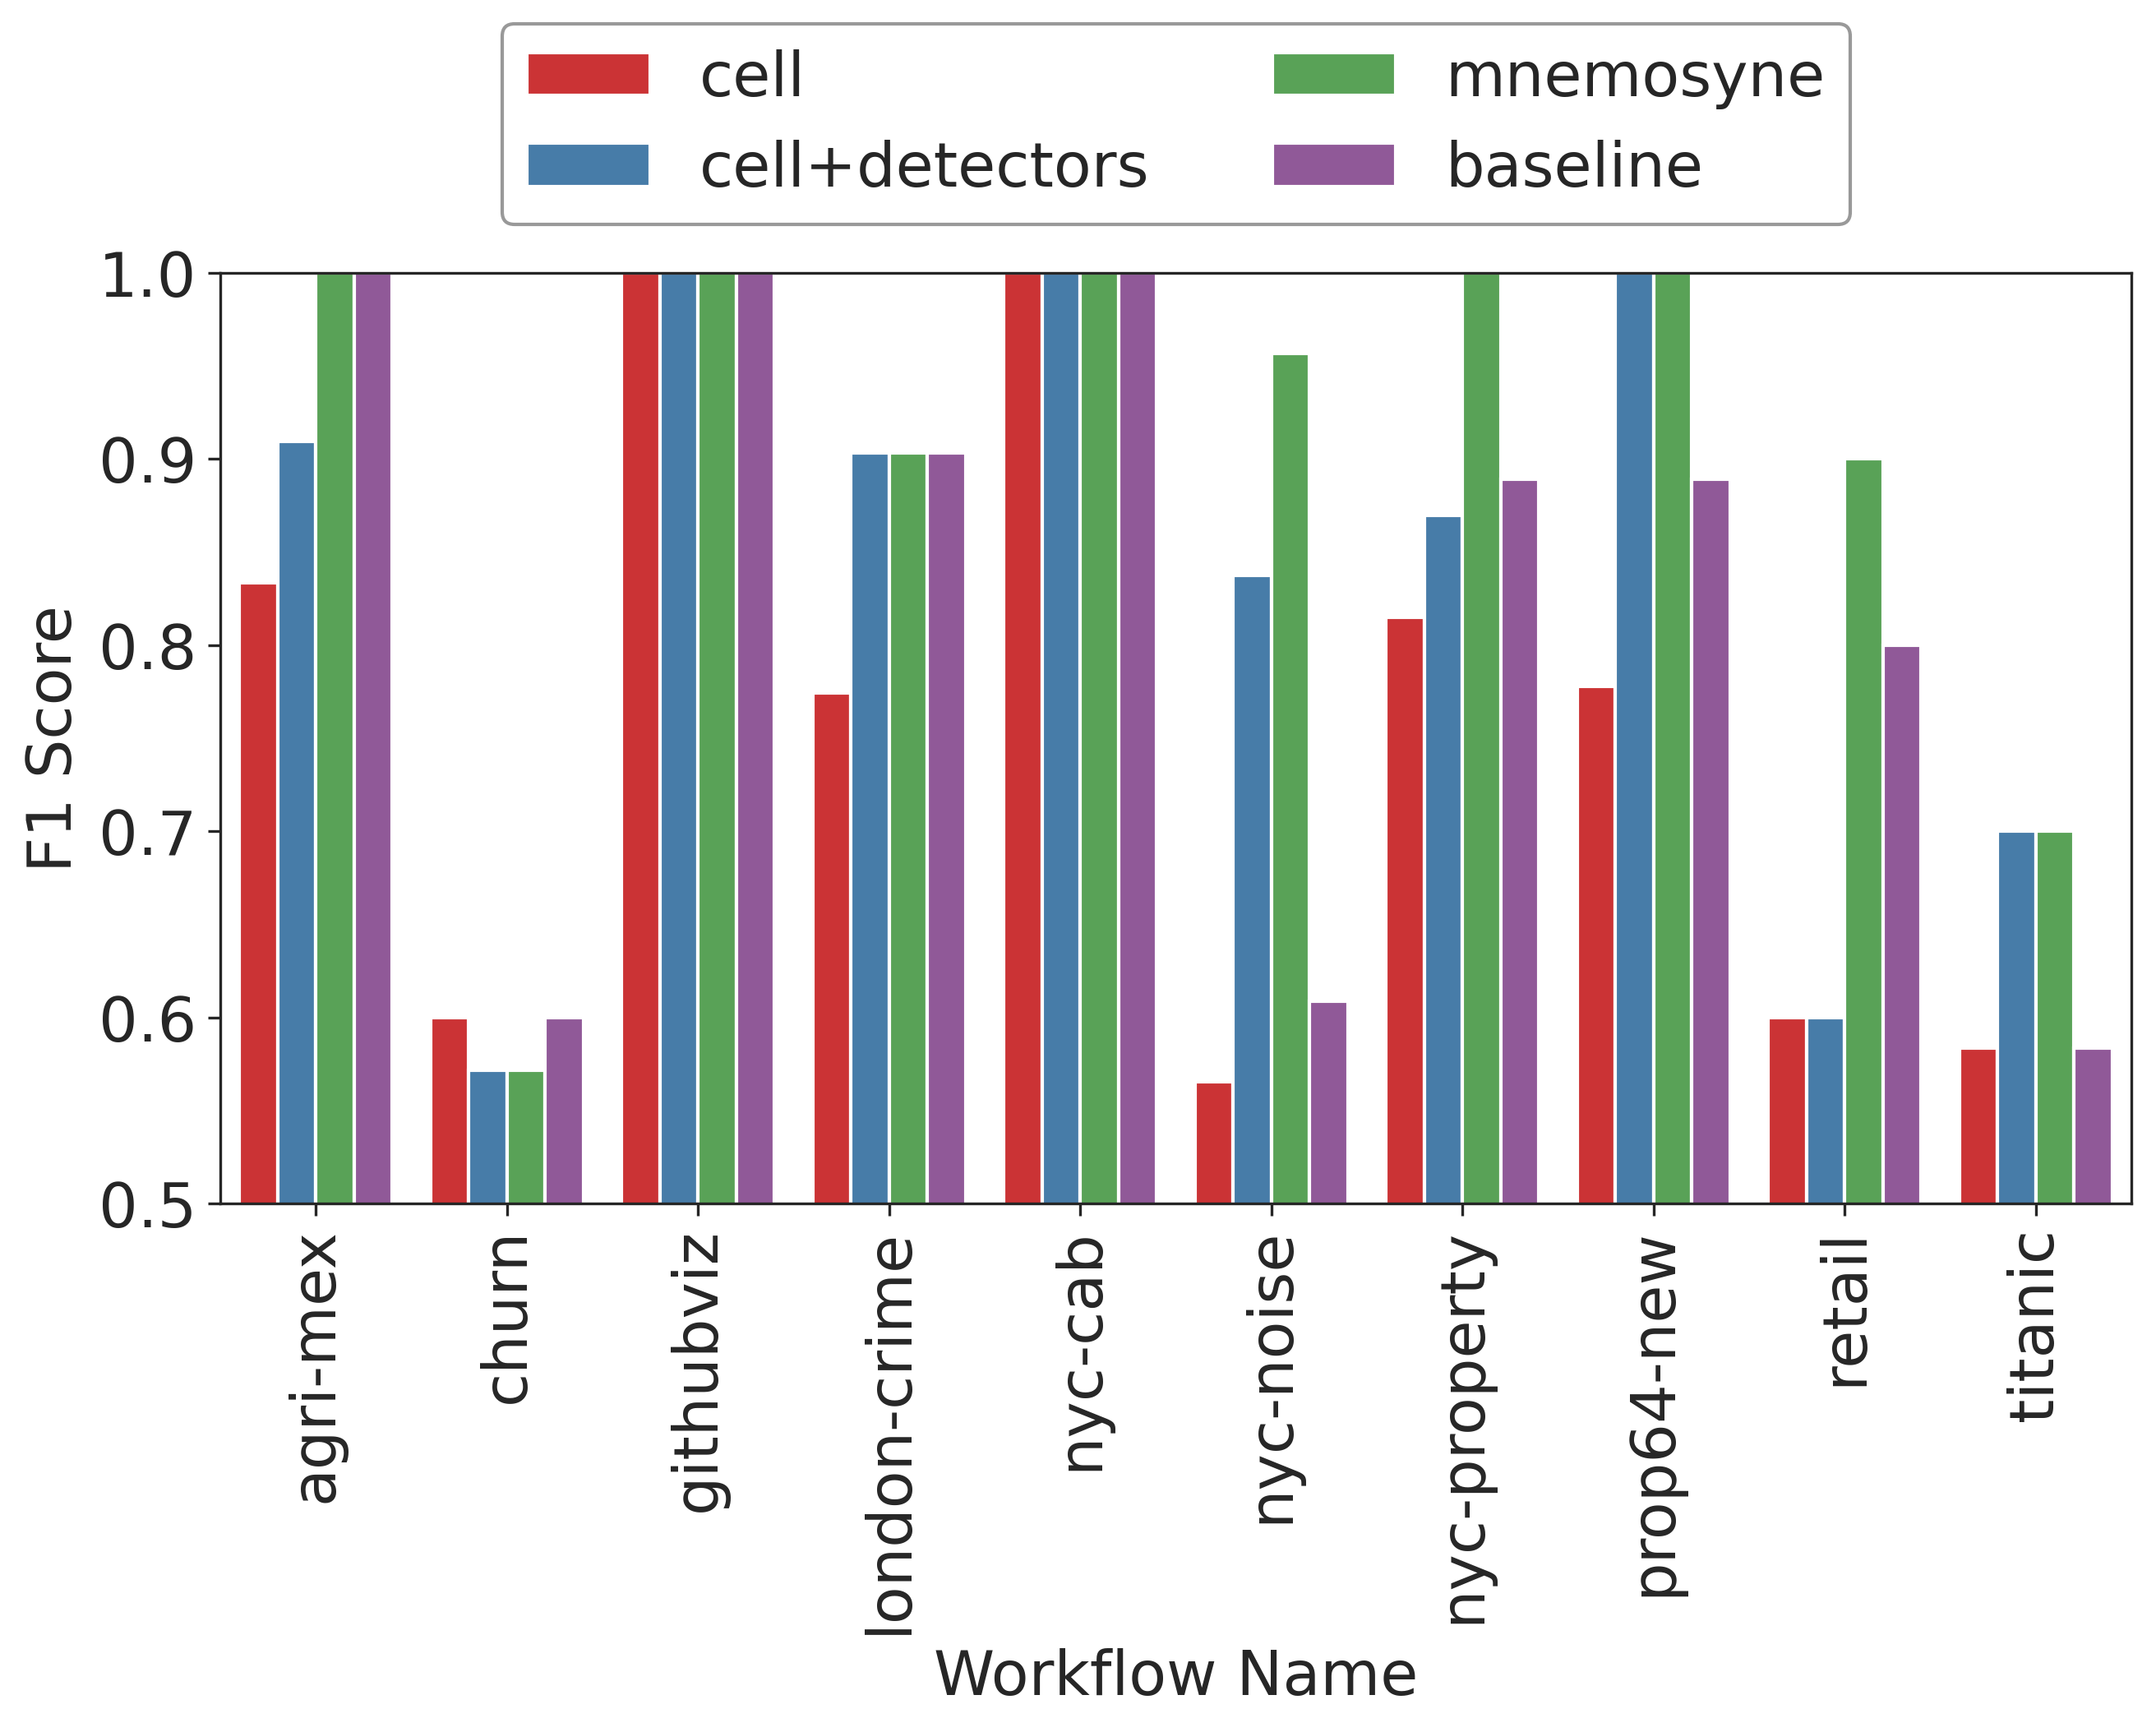

In [54]:
# Totals of Old F1 Score for each config
import seaborn as sns
import matplotlib.pyplot as plt

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18} #6}

plt.rc('font', **font)


#fig = plt.figure(num=None, figsize=set_size(text_width, fraction=0.5), dpi=300, facecolor='w', edgecolor='k')
fig = plt.figure(num=None, figsize=(10,5), dpi=300, facecolor='w', edgecolor='k')

sns.set_style("ticks")

order = ['cell', 'cell+group+join+pivot', 
         'pc2cell+group+join+pivot', 'pc2cell+containment+group+join+pivot','col']
order = ['cell', 'cell+group+join+pivot','pc2cell+containment+group+join+pivot','col']

chart = sns.barplot(x=agg_df1.nb, y='f1', hue="metric", data=agg_df1, 
                    palette="Set1", hue_order=order)
x_labels = chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
#L = plt.legend(loc='best')

#L = plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.25),edgecolor='grey')
L = plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.3),edgecolor='grey')


L.get_texts()[0].set_text('cell')
L.get_texts()[1].set_text('cell+detectors')
L.get_texts()[2].set_text('mnemosyne')
#L.get_texts()[3].set_text('clustering+cell+join+containment+group+pivot')
L.get_texts()[3].set_text('baseline')

plt.ylim(0.5,1.0)
plt.xlabel('Workflow Name')
plt.ylabel('F1 Score')

#g.add_legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
fig.savefig('real-1.pdf', bbox_inches='tight')

In [910]:
agg_df1.loc[agg_df1.metric == 'pc2cell+containment+group+join+pivot'].f1.mean()

0.9031176117010619

# Per Edge Type Breakdown

In [179]:
from collections import defaultdict


def compute_edge_precision_type1(df, t, g_truth_col='g_truth'):
    try:
        denominator = df.loc[df.type == t]
        numerator = denominator.loc[denominator[g_truth_col] == True]
        return len(numerator.index) / len(denominator.index)
    except ZeroDivisionError as e:
        return 0.0

def compute_edge_recall_type1(df, t, g_truth_col='g_truth'):
    try:
        denominator = df.loc[df[g_truth_col] == True]
        numerator = denominator.loc[denominator.type == t]
        return len(numerator.index) / len(denominator.index)
    except ZeroDivisionError as e:
        return 0.0

    
def compute_edge_recall_type2(df, t, g_truth_col='g_truth'):
    try:
        denominator = df.loc[(df[g_truth_col] == True) & (df.operation == t)]
        numerator = df.loc[(df.type == t) & (df[g_truth_col] == True)]
        return len(numerator.index) / len(denominator.index)
    except ZeroDivisionError as e:
        return 0.0
    
def compute_total_precision(df, g_truth_col='g_truth'):
    try:
        numerator = df.loc[(df[g_truth_col] == True) & df.g_inferred == True]
        denominator = df.loc[df.g_inferred == True]
        return len(numerator.index) / len(denominator.index)
    except ZeroDivisionError as e:
        return 0.0

def compute_total_recall(df, g_truth_col='g_truth'):
    try:
        numerator = df.loc[(df[g_truth_col] == True) & df.g_inferred == True]
        denominator = df.loc[df[g_truth_col] == True]
        return len(numerator.index) / len(denominator.index)
    except ZeroDivisionError as e:
        return 0.0

metrics = ['cell', 'cell+group+join+pivot', 'pc2cell+group+join+pivot', 'pc2cell+containment+group+join+pivot', 
        'col', 'cc_con', 'cc_con+group+join+pivot', 'pc2cc_con+group+join+pivot']




'''
detectors = ['cell jaccard score',
 'column jaccard score',
 'cell containment score',
 'cell_containment (detector)',
 'groupby',
 'merge',
 'pivot']
'''

all_results = syn_results
#all_results = real_results
all_results = all_results.replace('join', 'merge')
all_results['type'] = all_results['type'].replace('cell_containment', 'cell_containment (detector)')
all_results['type'] = all_results['type'].replace('pc2cc_con', 'cell containment score')
all_results['type'] = all_results['type'].replace('cc_con', 'cell containment score')
all_results['type'] = all_results['type'].replace('col', 'column jaccard score')
all_results['type'] = all_results['type'].replace(to_replace=r'^cell$', value='cell jaccard score', regex=True)


#detectors = set(all_results.type.dropna().values)
detectors = ['cell jaccard score', 'column jaccard score', 'cell containment score',  'merge',
       'cell_containment (detector)', 'groupby', 'pivot']




result_dict = defaultdict(list)
for m in metrics:
    m_df = all_results.loc[all_results.metric == m]
    for d in detectors:
        result_dict[(m, 'precision')].append(compute_edge_precision_type1(m_df,d))
        if d in ['groupby', 'merge', 'pivot']:
            result_dict[(m, 'recall')].append(compute_edge_recall_type2(m_df,d))
        else:
            result_dict[(m, 'recall')].append(compute_edge_recall_type1(m_df,d))
    result_dict[(m, 'precision')].append(compute_total_precision(m_df))
    result_dict[(m, 'recall')].append(compute_total_recall(m_df)) 

results = pd.DataFrame(result_dict, index=list(detectors)+['Total'])
results

cell           cell+group+join+pivot  \
                            precision    recall             precision   
cell jaccard score           0.797215  0.797215              0.941814   
column jaccard score         0.000000  0.000000              0.000000   
cell containment score       0.000000  0.000000              0.000000   
merge                        0.000000  0.000000              0.993781   
cell_containment (detector)  0.000000  0.000000              0.000000   
groupby                      0.000000  0.000000              0.587037   
pivot                        0.000000  0.000000              0.364865   
Total                        0.797215  0.797215              0.893418   

                                      pc2cell+group+join+pivot            \
                               recall                precision    recall   
cell jaccard score           0.695304                 0.957732  0.677974   
column jaccard score         0.000000                 0.000000  0.000000   
cell containment score       0.000000                 0.000000  0.000000   
merge                        0.743948                 0.994393  0.990689   
cell_containment (detector)  0.000000                 0.000000  0.000000   
groupby                      0.518822                 0.609195  0.520458   
pivot                        0.332308                 0.363946  0.329231   
Total                        0.876611                 0.910128  0.898534   

                            pc2cell+containment+group+join+pivot            \
                                                       precision    recall   
cell jaccard score                                      0.957732  0.677974   
column jaccard score                                    0.000000  0.000000   
cell containment score                                  0.000000  0.000000   
merge                                                   0.994393  0.990689   
cell_containment (detector)                             0.669231  0.025774   
groupby                                                 0.690476  0.379705   
pivot                                                   0.380435  0.323077   
Total                                                   0.915340  0.911272   

                                  col              cc_con         \
                            precision    recall precision recall   
cell jaccard score           0.000000  0.000000       0.0    0.0   
column jaccard score         0.832025  0.832025       0.0    0.0   
cell containment score       0.000000  0.000000       0.0    0.0   
merge                        0.000000  0.000000       0.0    0.0   
cell_containment (detector)  0.000000  0.000000       0.0    0.0   
groupby                      0.000000  0.000000       0.0    0.0   
pivot                        0.000000  0.000000       0.0    0.0   
Total                        0.832025  0.832025       0.0    0.0   

                            cc_con+group+join+pivot         \
                                          precision recall   
cell jaccard score                              0.0    0.0   
column jaccard score                            0.0    0.0   
cell containment score                          0.0    0.0   
merge                                           0.0    0.0   
cell_containment (detector)                     0.0    0.0   
groupby                                         0.0    0.0   
pivot                                           0.0    0.0   
Total                                           0.0    0.0   

                            pc2cc_con+group+join+pivot         
                                             precision recall  
cell jaccard score                                 0.0    0.0  
column jaccard score                               0.0    0.0  
cell containment score                             0.0    0.0  
merge                                              0.0    0.0  
cell_containment (detector)                        0.0    0.0  
groupby   

In [181]:
result_dict = defaultdict(list)

all_results = new_results
all_results = all_results.replace('join', 'merge')
all_results['type'] = all_results['type'].replace('cell_containment', 'cell_containment (detector)')
all_results['type'] = all_results['type'].replace('pc2cc_con', 'cell containment score')
all_results['type'] = all_results['type'].replace('cc_con', 'cell containment score')
all_results['type'] = all_results['type'].replace('col', 'column jaccard score')
all_results['type'] = all_results['type'].replace(to_replace=r'^cell$', value='cell jaccard score', regex=True)


#detectors = set(all_results.type.dropna().values)
detectors = ['cell jaccard score', 'column jaccard score', 'cell containment score',  'merge',
       'cell_containment (detector)', 'groupby', 'pivot']


for m in metrics:
    m_df = all_results.loc[all_results.metric == m]
    for d in detectors:
        result_dict[(m, 'precision')].append(compute_edge_precision_type1(m_df,d, g_truth_col = 'alt_g_truth'))
        if d in ['groupby', 'merge', 'pivot']:
            result_dict[(m, 'recall')].append(compute_edge_recall_type2(m_df,d, g_truth_col = 'alt_g_truth'))
        else:
            result_dict[(m, 'recall')].append(compute_edge_recall_type1(m_df,d, g_truth_col = 'alt_g_truth'))
    result_dict[(m, 'precision')].append(compute_total_precision(m_df, g_truth_col = 'alt_g_truth'))
    result_dict[(m, 'recall')].append(compute_total_recall(m_df, g_truth_col = 'alt_g_truth')) 

alt_results = pd.DataFrame(result_dict, index=list(detectors)+['Total'])
alt_results

cell           cell+group+join+pivot  \
                            precision    recall             precision   
cell jaccard score           0.797215  0.797215              0.941814   
column jaccard score         0.000000  0.000000              0.000000   
cell containment score       0.000000  0.000000              0.000000   
merge                        0.000000  0.000000              0.993781   
cell_containment (detector)  0.000000  0.000000              0.000000   
groupby                      0.000000  0.000000              0.757407   
pivot                        0.000000  0.000000              0.979730   
Total                        0.797215  0.797215              0.934783   

                                      pc2cell+group+join+pivot            \
                               recall                precision    recall   
cell jaccard score           0.668185                 0.957732  0.651716   
column jaccard score         0.000000                 0.000000  0.000000   
cell containment score       0.000000                 0.000000  0.000000   
merge                        0.743948                 0.994393  0.990689   
cell_containment (detector)  0.000000                 0.000000  0.000000   
groupby                      0.669394                 0.781609  0.667758   
pivot                        0.892308                 0.982993  0.889231   
Total                        0.881423                 0.950938  0.902463   

                            pc2cell+containment+group+join+pivot            \
                                                       precision    recall   
cell jaccard score                                      0.957732  0.654231   
column jaccard score                                    0.000000  0.000000   
cell containment score                                  0.000000  0.000000   
merge                                                   0.994393  0.990689   
cell_containment (detector)                             0.669231  0.024871   
groupby                                                 0.916667  0.504092   
pivot                                                   0.992754  0.843077   
Total                                                   0.951793  0.914380   

                                  col              cc_con         \
                            precision    recall precision recall   
cell jaccard score           0.000000  0.000000       0.0    0.0   
column jaccard score         0.832025  0.832025       0.0    0.0   
cell containment score       0.000000  0.000000       0.0    0.0   
merge                        0.000000  0.000000       0.0    0.0   
cell_containment (detector)  0.000000  0.000000       0.0    0.0   
groupby                      0.000000  0.000000       0.0    0.0   
pivot                        0.000000  0.000000       0.0    0.0   
Total                        0.832025  0.832025       0.0    0.0   

                            cc_con+group+join+pivot         \
                                          precision recall   
cell jaccard score                              0.0    0.0   
column jaccard score                            0.0    0.0   
cell containment score                          0.0    0.0   
merge                                           0.0    0.0   
cell_containment (detector)                     0.0    0.0   
groupby                                         0.0    0.0   
pivot                                           0.0    0.0   
Total                                           0.0    0.0   

                            pc2cc_con+group+join+pivot         
                                             precision recall  
cell jaccard score                                 0.0    0.0  
column jaccard score                               0.0    0.0  
cell containment score                             0.0    0.0  
merge                                              0.0    0.0  
cell_containment (detector)                        0.0    0.0  
groupby   

In [178]:
pc2result = results['pc2cell+containment+group+join+pivot']
pc2result.loc[(pc2result.precision > 0) & (pc2result.recall >0)]

,precision,recall
cell jaccard score,0.957732,0.677974
merge,0.994393,0.990689
cell_containment (detector),0.669231,0.025774
groupby,0.690476,0.379705
pivot,0.380435,0.323077
Total,0.915340,0.911272


In [182]:
pc2result = alt_results['pc2cell+containment+group+join+pivot']
pc2result.loc[(pc2result.precision > 0) & (pc2result.recall >0)]

,precision,recall
cell jaccard score,0.957732,0.654231
merge,0.994393,0.990689
cell_containment (detector),0.669231,0.024871
groupby,0.916667,0.504092
pivot,0.992754,0.843077
Total,0.951793,0.914380


In [567]:
# Rename operations to align with expected naming convention for detector breakdown

rename_dict = {
 'drop col': 'dropcol',
 'split': 'sample',
 'select': 'sample',
 'add features': 'apply',
 'crosstab': 'pivot',
 'dropcols': 'dropcol',
 'newcol': 'apply',
 'normalize': 'transform',
 'value transform': 'transform',
 'dropped columns': 'dropcol',
 'scaled transform': 'transform',
 'drop cols': 'dropcol',
 'fillna': 'point_edit',
 'point_correction': 'point_edit',
 'isnull': 'sample',
 'new derived column': 'apply',
 'drop': 'dropcol',
 'filter': 'sample',
 'rename column': 'apply',
 'projection': 'dropcol',
 'columnvalmapping': 'transform',
 'derived column': 'apply'
}


In [579]:
# Real Workflow Breakdown
real_renamed = real_results.copy().replace({'operation': rename_dict})
real_renamed.operation.value_counts

,src,dest,notebook,metric,g_inferred,g_truth,stage_0,stage_1,stage_1_weight,type,...,stage_3_inter,stage_3_inter_weight,stage_1_intra1,stage_1_intra1_weight,stage_1_intra1_op,stage_1_intra2,stage_1_intra2_weight,stage_1_intra2_op,stage_3_inter_op,stage_2_join_op
0,noise_c.csv,hr_type_data.csv,nyc-noise,cell,False,False,input,considered,0.000005,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,noise_c.csv,wd_type_detail_wide.csv,nyc-noise,cell,False,False,input,considered,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,noise_c.csv,noise_c__2.csv,nyc-noise,cell,False,False,input,considered,0.903226,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,noise_c.csv,noise_open.csv,nyc-noise,cell,False,False,input,considered,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,noise_c.csv,wd_data.csv,nyc-noise,cell,False,False,input,considered,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,extract_user_repo.csv,repos-dump.csv,githubviz,col,True,True,input,considered,0.714286,col,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,extract_user_repo.csv,repo_users_ranks.csv,githubviz,col,False,False,input,considered,0.466667,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,users_ren_col.csv,repos-dump.csv,githubviz,col,False,False,input,considered,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,users_ren_col.csv,repo_users_ranks.csv,githubviz,col,False,False,input,considered,0.533333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [583]:
all_results = real_renamed
all_results = all_results.replace('join', 'merge')
all_results['type'] = all_results['type'].replace('cell_containment', 'cell_containment (detector)')
all_results['type'] = all_results['type'].replace('pc2cc_con', 'cell containment score')
all_results['type'] = all_results['type'].replace('cc_con', 'cell containment score')
all_results['type'] = all_results['type'].replace('col', 'column jaccard score')
all_results['type'] = all_results['type'].replace(to_replace=r'^cell$', value='cell jaccard score', regex=True)


#detectors = set(all_results.type.dropna().values)
detectors = ['cell jaccard score', 'column jaccard score', 'cell containment score',  'merge',
       'cell_containment (detector)', 'groupby', 'pivot']


result_dict = defaultdict(list)
for m in metrics:
    m_df = all_results.loc[all_results.metric == m]
    for d in detectors:
        result_dict[(m, 'precision')].append(compute_edge_precision_type1(m_df,d))
        if d in ['groupby', 'merge', 'pivot']:
            result_dict[(m, 'recall')].append(compute_edge_recall_type2(m_df,d))
        else:
            result_dict[(m, 'recall')].append(compute_edge_recall_type1(m_df,d))
    result_dict[(m, 'precision')].append(compute_total_precision(m_df))
    result_dict[(m, 'recall')].append(compute_total_recall(m_df)) 

results = pd.DataFrame(result_dict, index=list(detectors)+['Total'])
results

col             cell         \
                            precision recall precision recall   
cell jaccard score              0.000  0.000     0.728  0.728   
column jaccard score            0.808  0.808     0.000  0.000   
cell containment score          0.000  0.000     0.000  0.000   
merge                           0.000  0.000     0.000  0.000   
cell_containment (detector)     0.000  0.000     0.000  0.000   
groupby                         0.000  0.000     0.000  0.000   
pivot                           0.000  0.000     0.000  0.000   
Total                           0.808  0.808     0.728  0.728   

                            pc2cell+group+join+pivot            \
                                           precision    recall   
cell jaccard score                          0.963855  0.640000   
column jaccard score                        0.000000  0.000000   
cell containment score                      0.000000  0.000000   
merge                                       1.000000  0.857143   
cell_containment (detector)                 0.000000  0.000000   
groupby                                     0.833333  0.833333   
pivot                                       1.000000  0.666667   
Total                                       0.954955  0.848000   

                            cell+group+join+pivot            \
                                        precision    recall   
cell jaccard score                       0.880952  0.592000   
column jaccard score                     0.000000  0.000000   
cell containment score                   0.000000  0.000000   
merge                                    1.000000  0.714286   
cell_containment (detector)              0.000000  0.000000   
groupby                                  0.833333  0.833333   
pivot                                    1.000000  0.666667   
Total                                    0.890909  0.784000   

                            pc2cell+containment+group+join+pivot            
                                                       precision    recall  
cell jaccard score                                      0.963855  0.640000  
column jaccard score                                    0.000000  0.000000  
cell containment score                                  0.000000  0.000000  
merge                                                   1.000000  0.857143  
cell_containment (detector)                             1.000000  0.048000  
groupby                                                 0.833333  0.833333  
pivot                                                   1.000000  0.666667  
Total                                                   0.957265  0.896000

In [584]:
pc2result = results['pc2cell+containment+group+join+pivot']
pc2result.loc[(pc2result.precision > 0) & (pc2result.recall >0)]

,precision,recall
cell jaccard score,0.963855,0.640000
merge,1.000000,0.857143
cell_containment (detector),1.000000,0.048000
groupby,0.833333,0.833333
pivot,1.000000,0.666667
Total,0.957265,0.896000


# Timing Graphs


In [912]:
T_RESULT_DIR = '/home/suhail/Projects/relic/primitives/python/generator/dataset_flat_timing/'
t_notebooks = [d for d in os.listdir(T_RESULT_DIR) if os.path.isdir(os.path.join(RESULT_DIR, d))]

In [913]:
import glob
import os

def get_notebook_result(result_dir, nb, filename='relic_agglomerative_result.csv'):
    return pd.read_csv(result_dir+'/'+nb+'/'+filename, index_col=0)

def timing_results(RESULT_DIR):
    result = pd.DataFrame()
    
    notebooks = [d for d in os.listdir(RESULT_DIR) if os.path.isdir(os.path.join(RESULT_DIR, d))]
    for nb in notebooks:
        try:          
            result_files = [os.path.basename(x) for x in glob.glob(RESULT_DIR+'/'+nb+'/*_relic_result.csv')]
            result_list = []
            
            for f in result_files:
                r = get_notebook_result(RESULT_DIR,nb, filename=f)
                result_list.append(r)
            
            combined = pd.DataFrame()
            combined = combined.append(result_list)
            result = result.append(combined)
        
        except FileNotFoundError as e:
            errors.append(nb)
            print(e)
            pass
    
    return result

In [914]:
t_df=timing_results(T_RESULT_DIR).reset_index(drop=True)
t_df

,nb_name,rows,columns,artifacts,index,numclusters,distance_metric,edges_correct,edges_missing,edges_to_remove,join_edges,precision,recall,F1,missing_files,time,pre_cluster,stage_name
0,20210126-153738,100,10,20,False,NaN,col,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.033172,No Precluster,load
1,20210126-153738,100,10,20,False,NaN,col,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.379733,No Precluster,col_pair_compute
2,20210126-153738,100,10,20,False,NaN,col,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.383819,No Precluster,clustrering
3,20210126-153738,100,10,20,False,11.0,col,18.0,1.0,1.0,NaN,0.947368,0.947368,0.947368,0.0,0.416634,No Precluster,1_flat
4,20210126-153738,100,10,20,False,NaN,pc2cell+containment+group+join+pivot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.033518,PC2,load
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1593,20210126-160531,100000,10,20,False,14.0,pc2cell+containment+group+join+pivot,15.0,4.0,1.0,NaN,0.937500,0.789474,0.857143,0.0,584.157256,PC2,3_inter
1594,20210126-160531,100000,10,20,False,14.0,pc2cell+containment+group+join+pivot,16.0,3.0,1.0,NaN,0.941176,0.842105,0.888889,0.0,1878.794342,PC2,4_group
1595,20210126-160531,100000,10,20,False,14.0,pc2cell+containment+group+join+pivot,16.0,3.0,1.0,NaN,0.941176,0.842105,0.888889,0.0,1878.799836,PC2,4_group
1596,20210126-160531,100000,10,20,False,14.0,pc2cell+containment+group+join+pivot,17.0,2.0,1.0,NaN,0.944444,0.894737,0.918919,0.0,1890.078409,PC2,5_pivot


In [915]:
t_df.artifacts.value_counts()

20    1598
Name: artifacts, dtype: int64

In [916]:
stage_rename = {
    'load': '00_load',
    'cell_pair_compute': '01_pairwise_cell',
    'contain_pair_compute': '02_pairwise_cell_containment',
    'clustrering': '03_clustering',
    '1_flat': '04_flat',
    '1_intra': '05_intra',
    '1_intra2': '05_intra',
    '2_join': '06_join',
    '3_inter': '07_inter',
    '4_group': '08_groupby',
    '5_pivot': '09_pivot',
}

t_df['stage_name'] = t_df['stage_name'].replace(stage_rename)
t_df

,nb_name,rows,columns,artifacts,index,numclusters,distance_metric,edges_correct,edges_missing,edges_to_remove,join_edges,precision,recall,F1,missing_files,time,pre_cluster,stage_name
0,20210126-153738,100,10,20,False,NaN,col,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.033172,No Precluster,00_load
1,20210126-153738,100,10,20,False,NaN,col,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.379733,No Precluster,col_pair_compute
2,20210126-153738,100,10,20,False,NaN,col,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.383819,No Precluster,03_clustering
3,20210126-153738,100,10,20,False,11.0,col,18.0,1.0,1.0,NaN,0.947368,0.947368,0.947368,0.0,0.416634,No Precluster,04_flat
4,20210126-153738,100,10,20,False,NaN,pc2cell+containment+group+join+pivot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.033518,PC2,00_load
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1593,20210126-160531,100000,10,20,False,14.0,pc2cell+containment+group+join+pivot,15.0,4.0,1.0,NaN,0.937500,0.789474,0.857143,0.0,584.157256,PC2,07_inter
1594,20210126-160531,100000,10,20,False,14.0,pc2cell+containment+group+join+pivot,16.0,3.0,1.0,NaN,0.941176,0.842105,0.888889,0.0,1878.794342,PC2,08_groupby
1595,20210126-160531,100000,10,20,False,14.0,pc2cell+containment+group+join+pivot,16.0,3.0,1.0,NaN,0.941176,0.842105,0.888889,0.0,1878.799836,PC2,08_groupby
1596,20210126-160531,100000,10,20,False,14.0,pc2cell+containment+group+join+pivot,17.0,2.0,1.0,NaN,0.944444,0.894737,0.918919,0.0,1890.078409,PC2,09_pivot


In [917]:
grouped = t_df.groupby(['nb_name','distance_metric','stage_name']).max().reset_index()
grouped

,nb_name,distance_metric,stage_name,rows,columns,artifacts,index,numclusters,edges_correct,edges_missing,edges_to_remove,join_edges,precision,recall,F1,missing_files,time,pre_cluster
0,20210126-153738,col,00_load,100,10,20,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.033172,No Precluster
1,20210126-153738,col,03_clustering,100,10,20,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.383819,No Precluster
2,20210126-153738,col,04_flat,100,10,20,False,11.0,18.0,1.0,1.0,NaN,0.947368,0.947368,0.947368,0.0,0.416634,No Precluster
3,20210126-153738,col,col_pair_compute,100,10,20,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.379733,No Precluster
4,20210126-153738,pc2cell+containment+group+join+pivot,00_load,100,10,20,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.033518,PC2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,20210126-170349,pc2cell+containment+group+join+pivot,05_intra,100000,20,20,False,14.0,2.0,17.0,0.0,NaN,1.000000,0.105263,0.190476,0.0,141.847812,PC2
606,20210126-170349,pc2cell+containment+group+join+pivot,06_join,100000,20,20,False,14.0,6.0,15.0,0.0,NaN,1.000000,0.315789,0.480000,0.0,768.807576,PC2
607,20210126-170349,pc2cell+containment+group+join+pivot,07_inter,100000,20,20,False,14.0,17.0,12.0,1.0,NaN,1.000000,0.894737,0.918919,0.0,770.321456,PC2
608,20210126-170349,pc2cell+containment+group+join+pivot,08_groupby,100000,20,20,False,14.0,17.0,2.0,1.0,NaN,0.944444,0.894737,0.918919,0.0,770.353157,PC2


In [918]:
import numpy as np
grouped['timediff'] = grouped.groupby(['nb_name','distance_metric'])['time'].diff().fillna(grouped['time'])
grouped

,nb_name,distance_metric,stage_name,rows,columns,artifacts,index,numclusters,edges_correct,edges_missing,edges_to_remove,join_edges,precision,recall,F1,missing_files,time,pre_cluster,timediff
0,20210126-153738,col,00_load,100,10,20,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.033172,No Precluster,0.033172
1,20210126-153738,col,03_clustering,100,10,20,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.383819,No Precluster,0.350647
2,20210126-153738,col,04_flat,100,10,20,False,11.0,18.0,1.0,1.0,NaN,0.947368,0.947368,0.947368,0.0,0.416634,No Precluster,0.032815
3,20210126-153738,col,col_pair_compute,100,10,20,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.379733,No Precluster,-0.036901
4,20210126-153738,pc2cell+containment+group+join+pivot,00_load,100,10,20,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.033518,PC2,0.033518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,20210126-170349,pc2cell+containment+group+join+pivot,05_intra,100000,20,20,False,14.0,2.0,17.0,0.0,NaN,1.000000,0.105263,0.190476,0.0,141.847812,PC2,0.012209
606,20210126-170349,pc2cell+containment+group+join+pivot,06_join,100000,20,20,False,14.0,6.0,15.0,0.0,NaN,1.000000,0.315789,0.480000,0.0,768.807576,PC2,626.959764
607,20210126-170349,pc2cell+containment+group+join+pivot,07_inter,100000,20,20,False,14.0,17.0,12.0,1.0,NaN,1.000000,0.894737,0.918919,0.0,770.321456,PC2,1.513880
608,20210126-170349,pc2cell+containment+group+join+pivot,08_groupby,100000,20,20,False,14.0,17.0,2.0,1.0,NaN,0.944444,0.894737,0.918919,0.0,770.353157,PC2,0.031701


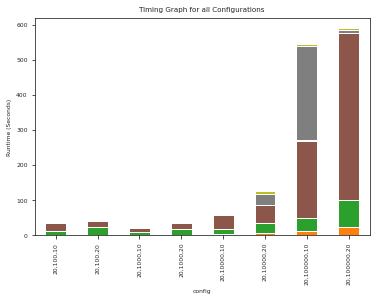

In [919]:
grouped = grouped.sort_values('nb_name')
grouped['config'] = grouped["artifacts"].astype(str) +','+ grouped["rows"].astype(str) + ',' +grouped["columns"].astype(str)

def draw_timing_graph(selected, title='Timing Graph for all Configurations', ax=None, index='config'):
    pivoted = selected.pivot(index=index, columns='stage_name', values='timediff').fillna(0)
    pivoted = pivoted.reindex(selected[index].drop_duplicates().values)

    chart = pivoted.plot.bar(stacked=True, ax=ax, legend=False)
    #chart.set_yscale('log')
    #L = plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    if not ax:
        plt.xlabel(index)
        plt.ylabel('Runtime (Seconds)')
        chart.set_title(title)

    
selected = grouped.loc[(grouped.distance_metric == 'pc2cell+containment+group+join+pivot') &
                       (grouped.artifacts == 20) &
                       (grouped.rows != 50000)].groupby(['config','stage_name']).mean().reset_index()
draw_timing_graph(selected)

#selected2 = grouped.loc[(grouped.distance_metric == 'pc2cell+containment+group+join+pivot') &
#                        (grouped.artifacts == 20)]
#draw_timing_graph(selected2, 'Runtime for 20 Artifacts')
#selected2 = grouped.loc[(grouped.distance_metric == 'pc2cell+containment+group+join+pivot') &
#                        (grouped.artifacts == 50)]
#draw_timing_graph(selected2, 'Runtime for 50 Artifacts')





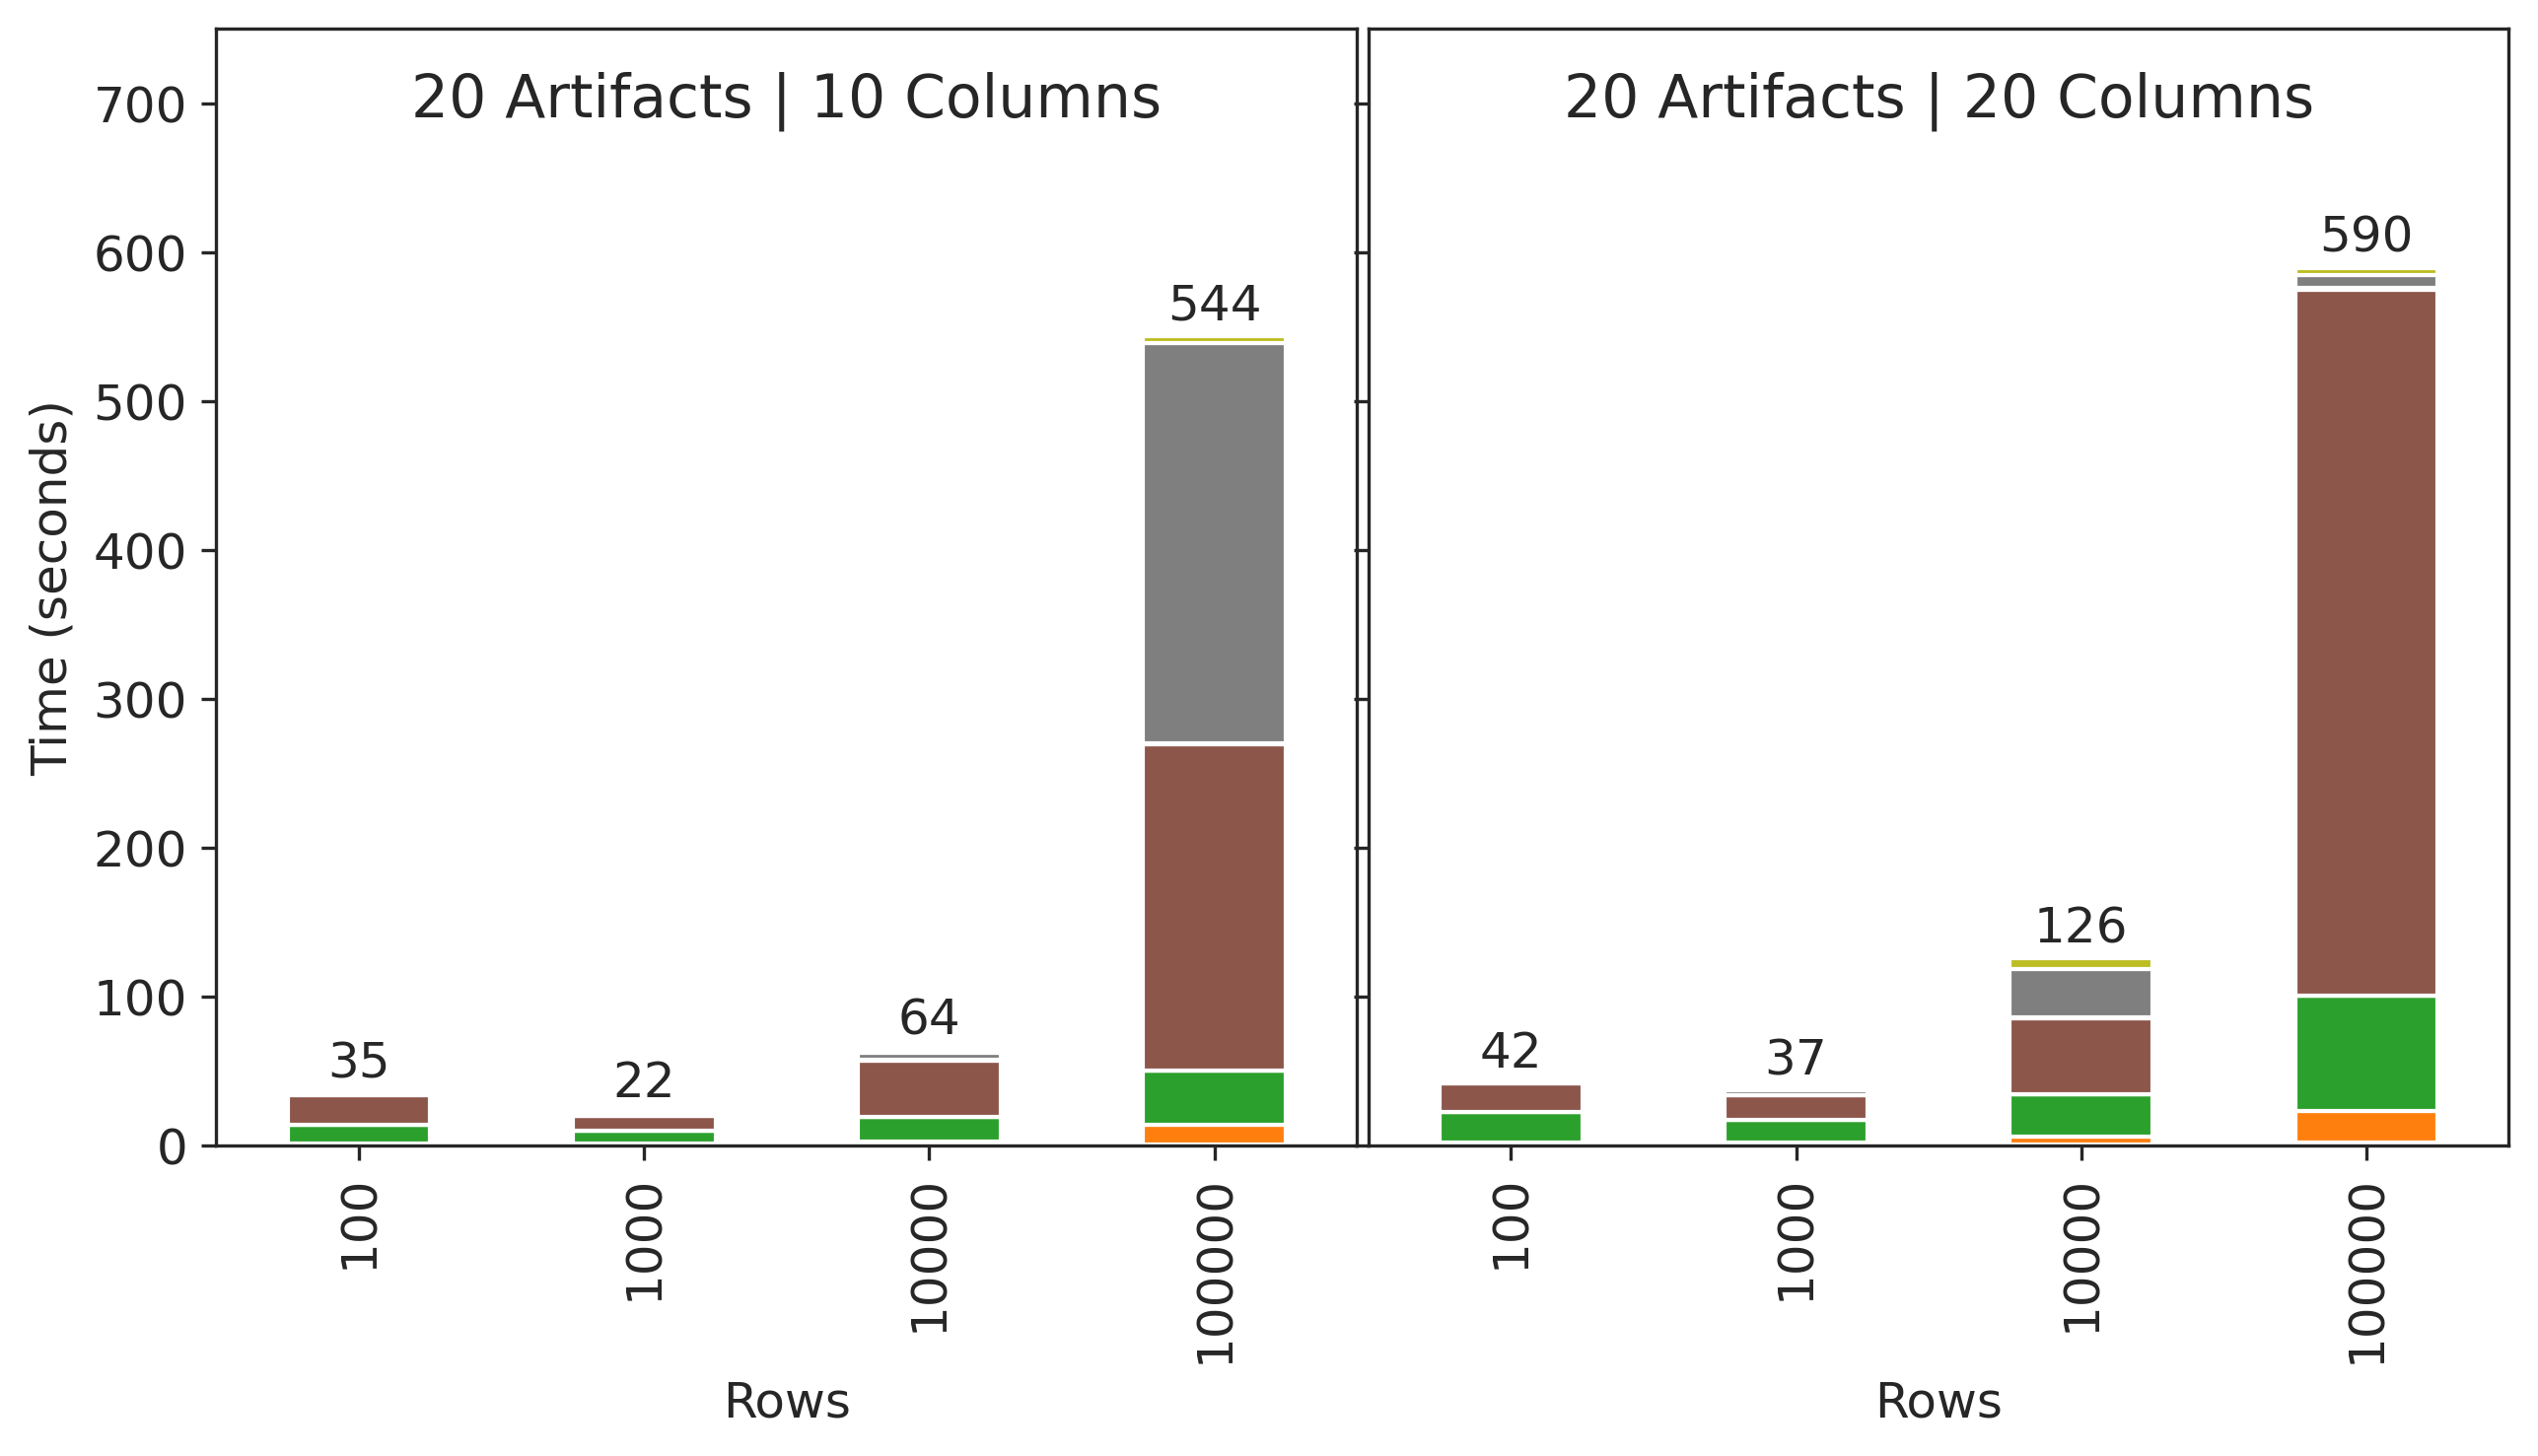

In [945]:
from itertools import product
# Timing Graph using the subplot
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

fig, axes = plt.subplots(1,2,figsize=(10,5), sharey=True, dpi=300)
fig.subplots_adjust(wspace=0.01)
axes = axes.flatten()

artifacts = [20,50]
columns = [10,20]

for i, ((a,c), ax) in enumerate(zip(product(artifacts,columns), axes)):
    #print(a,c,ax)
    
    selected = grouped.loc[(grouped.distance_metric == 'pc2cell+containment+group+join+pivot') &
                       (grouped.artifacts == a) &
                       (grouped['columns'] == c) &
                       (grouped.rows != 50000)].groupby(['config','stage_name']).mean().reset_index()
    draw_timing_graph(selected, title=str(c)+' Columns', ax=ax, index='rows')
    ax.set_ylim(0,750)
    ax.set_xlabel('Rows')
    ax.set_ylabel('Time (seconds)')
    ax.set_title(str(a)+' Artifacts | '+str(c)+' Columns', y=0.9)
    
    
    total_labels = [int(np.round(x)) for x in selected.groupby('config')['timediff'].sum().values]
    for i, tot in enumerate(total_labels):
        ax.text(i, tot+20, str(tot), va='center', ha='center')
    
    if i == 0:
        ax.legend(title='Stage', loc='upper left', bbox_to_anchor=(0,0.85))

fig.savefig('syn-timing.pdf', format='pdf', bbox_inches='tight')

In [935]:
selected

,config,stage_name,rows,columns,artifacts,index,numclusters,edges_correct,edges_missing,edges_to_remove,join_edges,precision,recall,F1,missing_files,time,timediff
0,"20,100,20",00_load,100,20,20,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.047753,0.047753
1,"20,100,20",01_pairwise_cell,100,20,20,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.168148,2.120395
2,"20,100,20",02_pairwise_cell_containment,100,20,20,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.442616,20.274468
3,"20,100,20",03_clustering,100,20,20,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.446641,0.004025
4,"20,100,20",05_intra,100,20,20,False,10.600000,8.200000,10.800000,0.200000,NaN,0.975000,0.431579,0.578273,0.0,22.461226,0.014585
5,"20,100,20",06_join,100,20,20,False,10.600000,13.800000,8.800000,0.200000,NaN,0.985714,0.726316,0.833267,0.0,41.814833,19.353607
6,"20,100,20",07_inter,100,20,20,False,10.600000,18.400000,4.200000,0.600000,NaN,0.988889,0.968421,0.978378,0.0,41.904058,0.089225
7,"20,1000,20",00_load,1000,20,20,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.062041,0.062041
8,"20,1000,20",01_pairwise_cell,1000,20,20,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.853447,1.791406
9,"20,1000,20",02_pairwise_cell_containment,1000,20,20,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.045994,15.192547


In [937]:
total_labels = [str(int(np.round(x))) for x in selected.groupby('config')['timediff'].sum().values]
total_labels

['42', '37', '126', '590']

<ipython-input-347-64bbadd817a5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_times['TPA'] = total_times['time'] / total_times['artifacts']


Text(0, 0.5, 'Normalized Time Per Artifact (Seconds)')

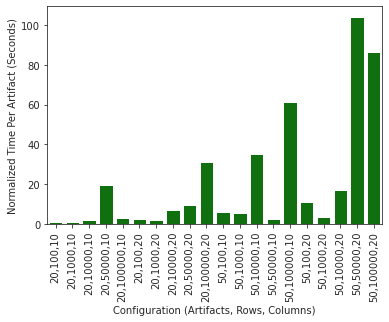

In [347]:
# Normalized Time per Artifact

idx = grouped.groupby(['nb_name', 'distance_metric'])['stage_name'].transform(max) == grouped['stage_name']
total_times = grouped[idx]

total_times['TPA'] = total_times['time'] / total_times['artifacts']

plot_data = total_times.loc[(total_times.distance_metric == 'pc2cell+containment+group+join+pivot')]

chart = sns.barplot(x=plot_data.config, y='TPA', data=plot_data, color='green')
x_labels = chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

plt.xlabel('Configuration (Artifacts, Rows, Columns)')
plt.ylabel('Normalized Time Per Artifact (Seconds)')


In [949]:
# Real workflow timings
T_RESULT_DIR = '/home/suhail/Projects/sample_workflows/million_notebooks/selected_timing/'
t_notebooks = [d for d in os.listdir(T_RESULT_DIR) if os.path.isdir(os.path.join(RESULT_DIR, d))]
t_df=timing_results(T_RESULT_DIR).reset_index(drop=True)
t_df

,nb_name,rows,columns,artifacts,index,numclusters,distance_metric,edges_correct,edges_missing,edges_to_remove,join_edges,precision,recall,F1,missing_files,time,pre_cluster,stage_name
0,nyc-noise,176,2,24,False,NaN,col,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.851465,No Precluster,load
1,nyc-noise,176,2,24,False,NaN,col,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.287391,No Precluster,col_pair_compute
2,nyc-noise,176,2,24,False,NaN,col,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.291717,No Precluster,clustrering
3,nyc-noise,176,2,24,False,15.0,col,14.0,9.0,9.0,NaN,0.608696,0.608696,0.608696,0.0,136.323254,No Precluster,1_flat
4,nyc-noise,176,2,24,False,NaN,pc2cell+containment+group+join+pivot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.642964,PC2,load
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,githubviz,8697,5,6,False,6.0,pc2cell+containment+group+join+pivot,2.0,3.0,0.0,NaN,1.000000,0.400000,0.571429,0.0,2.791366,PC2,2_join
241,githubviz,8697,5,6,False,6.0,pc2cell+containment+group+join+pivot,2.0,3.0,0.0,NaN,1.000000,0.400000,0.571429,0.0,2.796584,PC2,2_join
242,githubviz,8697,5,6,False,6.0,pc2cell+containment+group+join+pivot,3.0,2.0,0.0,NaN,1.000000,0.600000,0.750000,0.0,2.803533,PC2,3_inter
243,githubviz,8697,5,6,False,6.0,pc2cell+containment+group+join+pivot,4.0,1.0,0.0,NaN,1.000000,0.800000,0.888889,0.0,2.809314,PC2,3_inter


In [950]:
t_df['stage_name'] = t_df['stage_name'].replace(stage_rename)
t_df

,nb_name,rows,columns,artifacts,index,numclusters,distance_metric,edges_correct,edges_missing,edges_to_remove,join_edges,precision,recall,F1,missing_files,time,pre_cluster,stage_name
0,nyc-noise,176,2,24,False,NaN,col,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.851465,No Precluster,00_load
1,nyc-noise,176,2,24,False,NaN,col,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.287391,No Precluster,col_pair_compute
2,nyc-noise,176,2,24,False,NaN,col,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.291717,No Precluster,03_clustering
3,nyc-noise,176,2,24,False,15.0,col,14.0,9.0,9.0,NaN,0.608696,0.608696,0.608696,0.0,136.323254,No Precluster,04_flat
4,nyc-noise,176,2,24,False,NaN,pc2cell+containment+group+join+pivot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.642964,PC2,00_load
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,githubviz,8697,5,6,False,6.0,pc2cell+containment+group+join+pivot,2.0,3.0,0.0,NaN,1.000000,0.400000,0.571429,0.0,2.791366,PC2,06_join
241,githubviz,8697,5,6,False,6.0,pc2cell+containment+group+join+pivot,2.0,3.0,0.0,NaN,1.000000,0.400000,0.571429,0.0,2.796584,PC2,06_join
242,githubviz,8697,5,6,False,6.0,pc2cell+containment+group+join+pivot,3.0,2.0,0.0,NaN,1.000000,0.600000,0.750000,0.0,2.803533,PC2,07_inter
243,githubviz,8697,5,6,False,6.0,pc2cell+containment+group+join+pivot,4.0,1.0,0.0,NaN,1.000000,0.800000,0.888889,0.0,2.809314,PC2,07_inter


In [951]:
grouped = t_df.groupby(['nb_name','distance_metric','stage_name']).max().reset_index()
grouped

,nb_name,distance_metric,stage_name,rows,columns,artifacts,index,numclusters,edges_correct,edges_missing,edges_to_remove,join_edges,precision,recall,F1,missing_files,time,pre_cluster
0,agri-mex,col,00_load,1254,9,7,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.030233,No Precluster
1,agri-mex,col,03_clustering,1254,9,7,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.120592,No Precluster
2,agri-mex,col,04_flat,1254,9,7,False,4.0,6.0,0.0,0.0,NaN,1.000,1.000000,1.000000,0.0,0.125628,No Precluster
3,agri-mex,col,col_pair_compute,1254,9,7,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.116341,No Precluster
4,agri-mex,pc2cell+containment+group+join+pivot,00_load,1254,9,7,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.058564,PC2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,titanic,pc2cell+containment+group+join+pivot,05_intra,891,12,13,False,9.0,1.0,11.0,0.0,NaN,1.000,0.083333,0.153846,0.0,4.637783,PC2
116,titanic,pc2cell+containment+group+join+pivot,06_join,891,12,13,False,9.0,1.0,11.0,0.0,NaN,1.000,0.083333,0.153846,0.0,6.420847,PC2
117,titanic,pc2cell+containment+group+join+pivot,07_inter,891,12,13,False,9.0,7.0,10.0,1.0,NaN,1.000,0.583333,0.700000,0.0,6.589507,PC2
118,titanic,pc2cell+containment+group+join+pivot,08_groupby,891,12,13,False,9.0,7.0,5.0,1.0,NaN,0.875,0.583333,0.700000,0.0,6.601462,PC2


In [952]:
import numpy as np
grouped['timediff'] = grouped.groupby(['nb_name','distance_metric'])['time'].diff().fillna(grouped['time'])
grouped

,nb_name,distance_metric,stage_name,rows,columns,artifacts,index,numclusters,edges_correct,edges_missing,edges_to_remove,join_edges,precision,recall,F1,missing_files,time,pre_cluster,timediff
0,agri-mex,col,00_load,1254,9,7,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.030233,No Precluster,0.030233
1,agri-mex,col,03_clustering,1254,9,7,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.120592,No Precluster,0.090358
2,agri-mex,col,04_flat,1254,9,7,False,4.0,6.0,0.0,0.0,NaN,1.000,1.000000,1.000000,0.0,0.125628,No Precluster,0.005036
3,agri-mex,col,col_pair_compute,1254,9,7,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.116341,No Precluster,-0.009287
4,agri-mex,pc2cell+containment+group+join+pivot,00_load,1254,9,7,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.058564,PC2,0.058564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,titanic,pc2cell+containment+group+join+pivot,05_intra,891,12,13,False,9.0,1.0,11.0,0.0,NaN,1.000,0.083333,0.153846,0.0,4.637783,PC2,0.010406
116,titanic,pc2cell+containment+group+join+pivot,06_join,891,12,13,False,9.0,1.0,11.0,0.0,NaN,1.000,0.083333,0.153846,0.0,6.420847,PC2,1.783064
117,titanic,pc2cell+containment+group+join+pivot,07_inter,891,12,13,False,9.0,7.0,10.0,1.0,NaN,1.000,0.583333,0.700000,0.0,6.589507,PC2,0.168659
118,titanic,pc2cell+containment+group+join+pivot,08_groupby,891,12,13,False,9.0,7.0,5.0,1.0,NaN,0.875,0.583333,0.700000,0.0,6.601462,PC2,0.011955


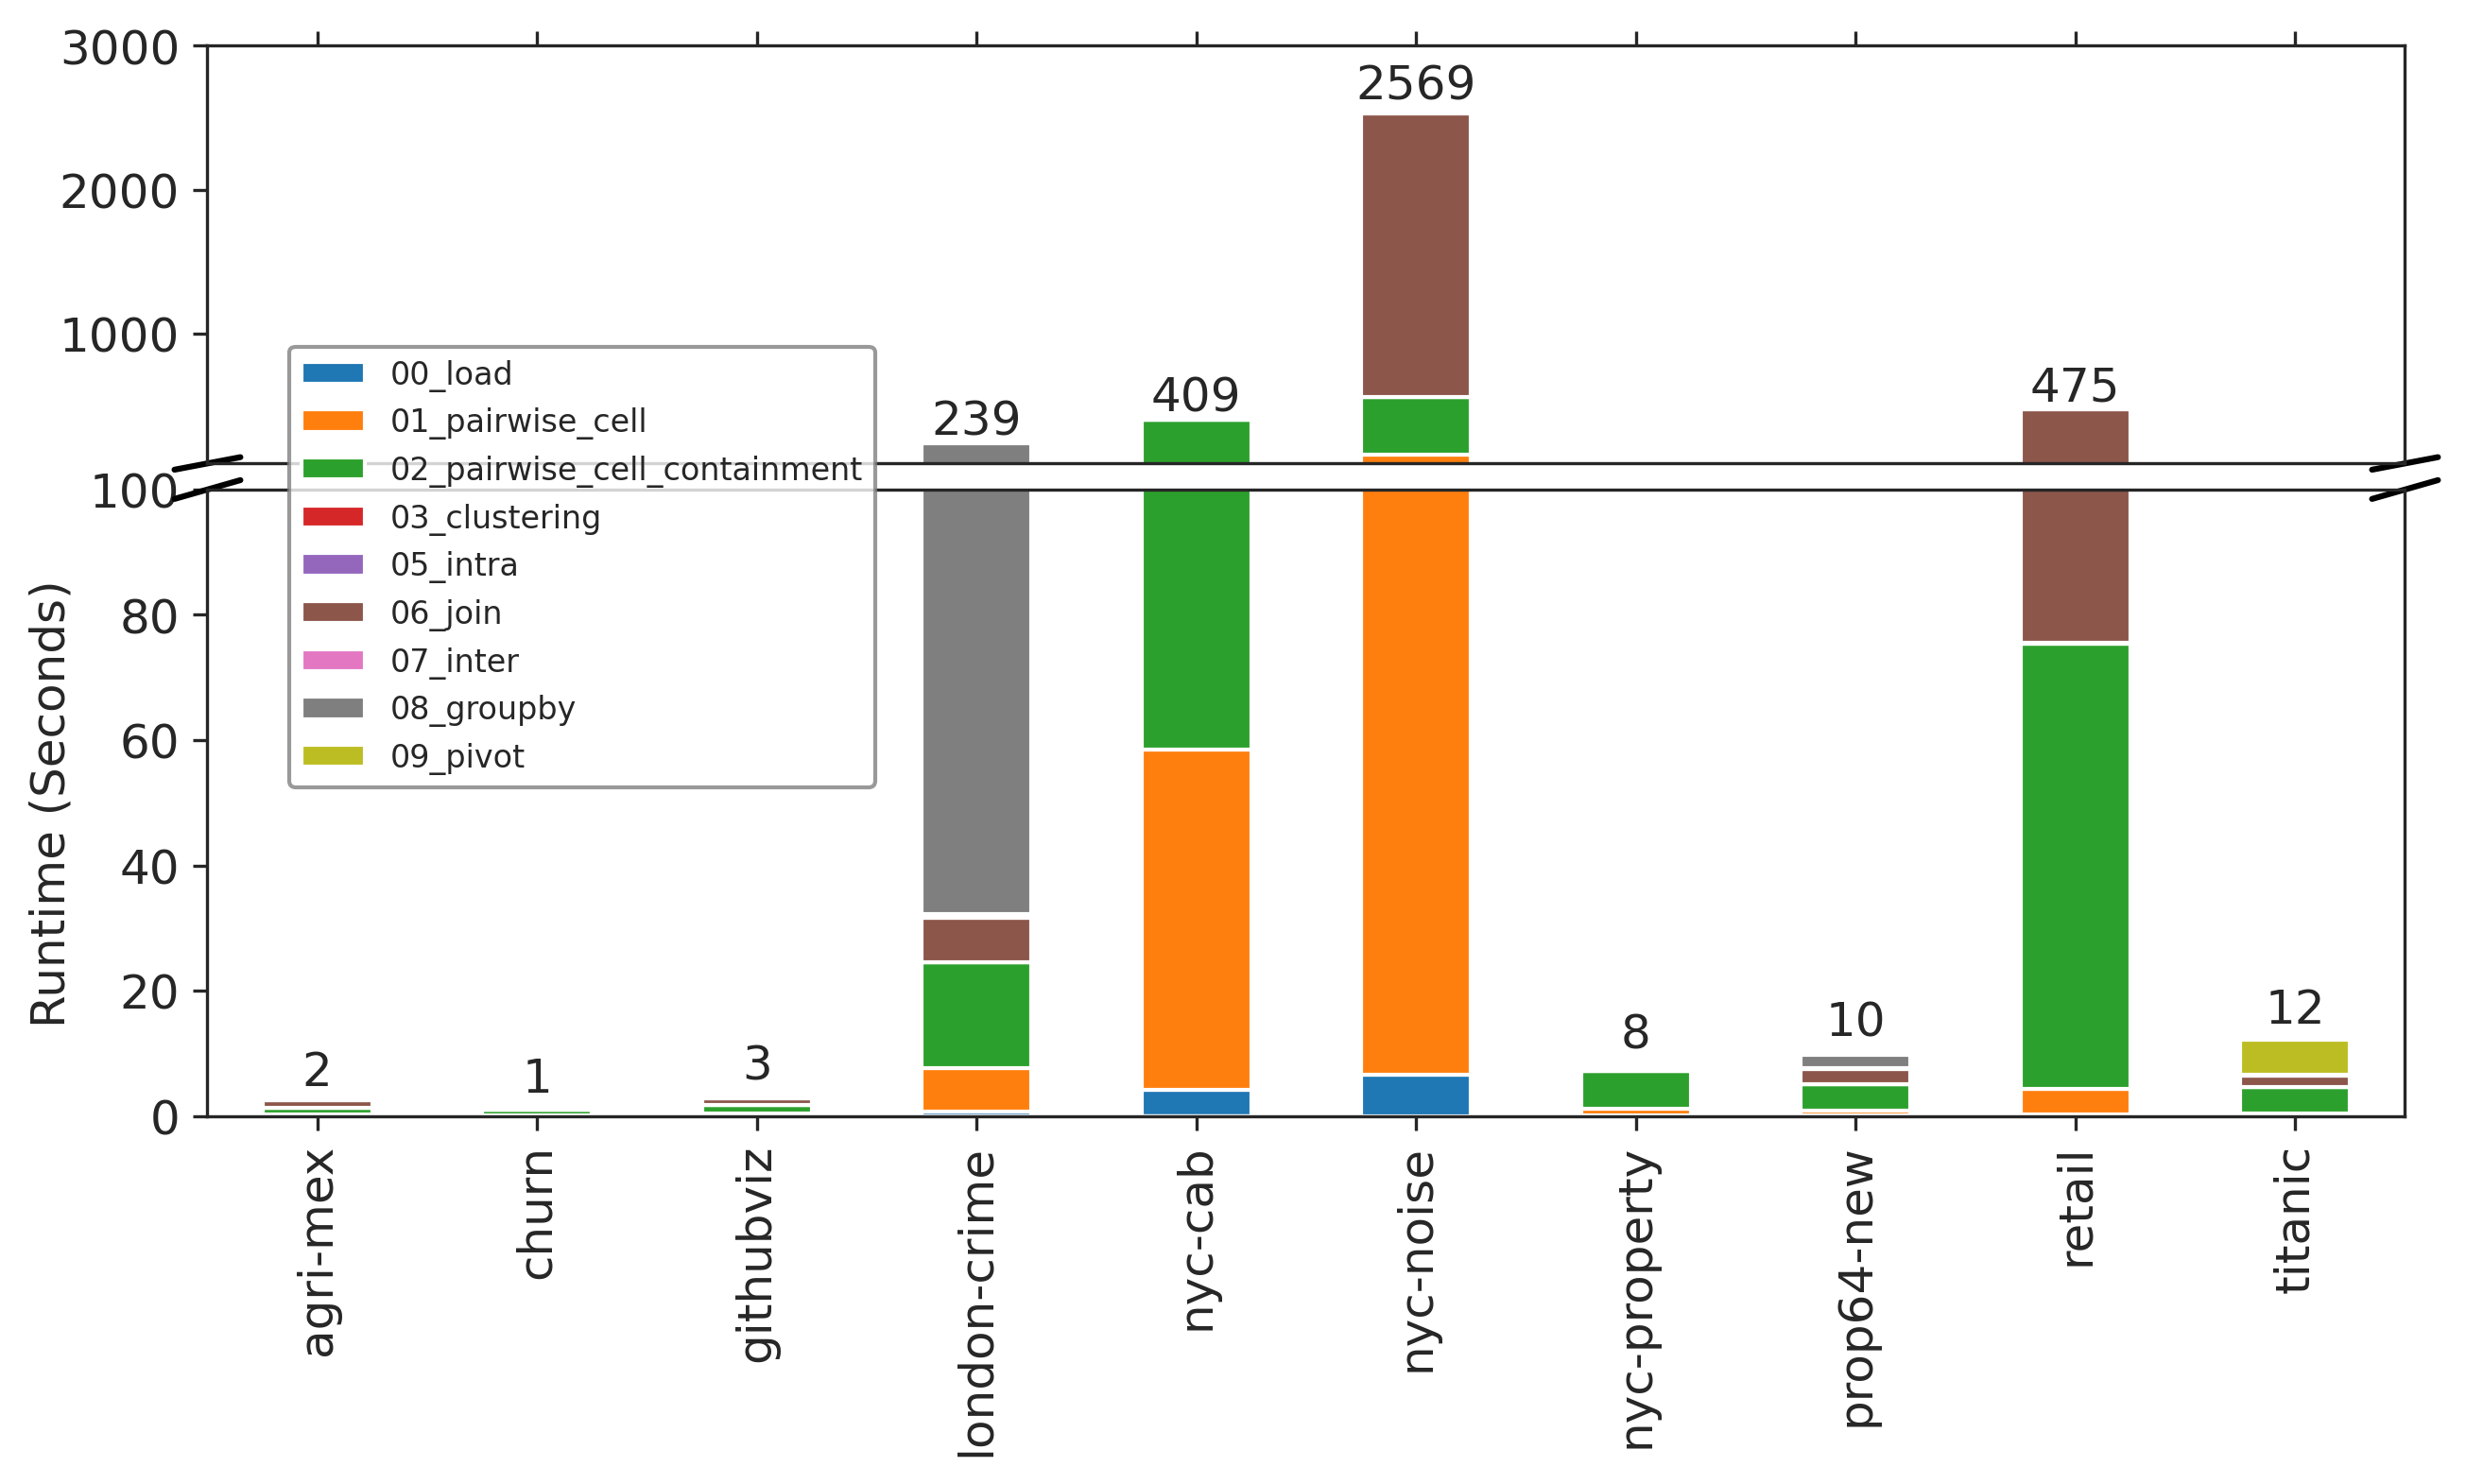

In [958]:
grouped = grouped.sort_values('nb_name')

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

def draw_real_timing_graph(selected, title='Timing Graph for all Configurations', ax=None, index='config'):
    pivoted = selected.pivot(index=index, columns='stage_name', values='timediff').fillna(0)
    pivoted = pivoted.reindex(selected[index].drop_duplicates().values)

    chart = pivoted.plot.bar(stacked=True, ax=ax, legend=False)
    #chart.set_yscale('log')
    #L = plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    if not ax:
        plt.xlabel(index)
        plt.ylabel('Runtime (Seconds)')
        chart.set_title(title)

fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2, 3]}, figsize=(10,5), dpi=300)
fig.subplots_adjust(hspace=0.05)

selected = grouped.loc[(grouped.distance_metric == 'pc2cell+containment+group+join+pivot')].groupby(['nb_name','stage_name']).mean().reset_index()
draw_timing_graph(selected, index='nb_name', title='Timing graph for Real Workflows', ax=ax)
ax.set_ylim(100,3000)

draw_timing_graph(selected, index='nb_name', title='Timing graph for Real Workflows', ax=ax2)
ax2.set_ylim(0,100)


#ax.spines['bottom'].set_visible(False)
#ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal



kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.ylabel('Runtime (Seconds)')
plt.xlabel('')


total_labels = [int(np.round(x)) for x in selected.groupby('nb_name')['timediff'].sum().values]
for i, tot in enumerate(total_labels):
    if tot > 100:
        ax.text(i, tot+150, str(tot), va='center', ha='center')
    else:
        ax2.text(i, tot+5, str(tot), va='center', ha='center')


L = plt.legend(loc='lower left', bbox_to_anchor=(0.03, 0.5),edgecolor='grey', prop={'size': 8})


fig.savefig('real-timing.pdf', format='pdf', bbox_inches='tight')

In [598]:
grouped

,nb_name,distance_metric,stage_name,rows,columns,artifacts,index,numclusters,edges_correct,edges_missing,edges_to_remove,join_edges,precision,recall,F1,missing_files,time,pre_cluster,timediff,config
0,agri-mex,col,00_load,1254,9,7,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.030233,No Precluster,0.030233,"7,1254,9"
2,agri-mex,col,04_flat,1254,9,7,False,4.0,6.0,0.0,0.0,NaN,1.000000,1.000000,1.000000,0.0,0.125628,No Precluster,0.005036,"7,1254,9"
5,agri-mex,pc2cell+containment+group+join+pivot,01_pairwise_cell,1254,9,7,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.229559,PC2,0.170995,"7,1254,9"
3,agri-mex,col,col_pair_compute,1254,9,7,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.116341,No Precluster,-0.009287,"7,1254,9"
4,agri-mex,pc2cell+containment+group+join+pivot,00_load,1254,9,7,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.058564,PC2,0.058564,"7,1254,9"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,titanic,pc2cell+containment+group+join+pivot,07_inter,891,12,13,False,9.0,7.0,10.0,1.0,NaN,1.000000,0.583333,0.700000,0.0,6.589507,PC2,0.168659,"13,891,12"
112,titanic,pc2cell+containment+group+join+pivot,01_pairwise_cell,891,12,13,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.456863,PC2,0.424653,"13,891,12"
114,titanic,pc2cell+containment+group+join+pivot,03_clustering,891,12,13,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.627377,PC2,0.003892,"13,891,12"
109,titanic,col,04_flat,891,12,13,False,9.0,7.0,5.0,5.0,NaN,0.583333,0.583333,0.583333,0.0,0.244164,No Precluster,0.009310,"13,891,12"


# Materialization Frequency 

In [886]:
# Materialization frequency:

RESULT_DIR = '/home/suhail/Projects/relic/primitives/python/generator/mattestnppexact/'

notebooks = sorted([d for d in os.listdir(RESULT_DIR) if os.path.isdir(os.path.join(RESULT_DIR, d))])

def experiment4_results():
    result = pd.DataFrame()
    for nb in notebooks:
        result = result.append(get_notebook_result(RESULT_DIR,nb, filename='pc2cell+containment+group+pivot_relic_result.csv').iloc[-1])
    return result

ex4_df = experiment4_results()

In [887]:
ex4_df['matfreq'] = np.repeat([1,2,4,8],5)
ex4_df

,F1,artifacts,columns,distance_metric,edges_correct,edges_missing,edges_to_remove,index,join_edges,missing_files,nb_name,numclusters,pre_cluster,precision,recall,rows,stage_name,time,matfreq
32,1.000000,50.0,20.0,pc2cell+containment+group+pivot,49.0,0.0,0.0,0.0,NaN,0.0,20210216-150432,32.0,PC2,1.000000,1.000000,1000.0,2_inter,2.570134,1
15,0.918367,50.0,20.0,pc2cell+containment+group+pivot,45.0,4.0,4.0,0.0,NaN,0.0,20210216-150503,15.0,PC2,0.918367,0.918367,1000.0,2_inter,0.913746,1
18,0.918367,50.0,20.0,pc2cell+containment+group+pivot,45.0,4.0,4.0,0.0,NaN,0.0,20210216-150537,18.0,PC2,0.918367,0.918367,1000.0,2_inter,1.179504,1
21,0.938776,50.0,20.0,pc2cell+containment+group+pivot,46.0,3.0,3.0,0.0,NaN,0.0,20210216-150609,21.0,PC2,0.938776,0.938776,1000.0,2_inter,1.991899,1
21,0.938776,50.0,20.0,pc2cell+containment+group+pivot,46.0,3.0,3.0,0.0,NaN,0.0,20210216-150645,21.0,PC2,0.938776,0.938776,1000.0,2_inter,208.696572,1
17,0.958333,25.0,20.0,pc2cell+containment+group+pivot,23.0,1.0,1.0,0.0,NaN,0.0,20210216-150718,17.0,PC2,0.958333,0.958333,1000.0,2_inter,0.575355,2
16,0.958333,25.0,20.0,pc2cell+containment+group+pivot,23.0,1.0,1.0,0.0,NaN,0.0,20210216-150739,16.0,PC2,0.958333,0.958333,1000.0,2_inter,0.336195,2
10,0.958333,25.0,20.0,pc2cell+containment+group+pivot,23.0,1.0,1.0,0.0,NaN,0.0,20210216-150754,10.0,PC2,0.958333,0.958333,1000.0,2_inter,50.114547,2
13,0.958333,25.0,20.0,pc2cell+containment+group+pivot,23.0,1.0,1.0,0.0,NaN,0.0,20210216-150812,12.0,PC2,0.958333,0.958333,1000.0,2_inter,49.119124,2
12,1.000000,25.0,20.0,pc2cell+containment+group+pivot,24.0,0.0,0.0,0.0,NaN,0.0,20210216-150829,12.0,PC2,1.000000,1.000000,1000.0,2_inter,47.941588,2


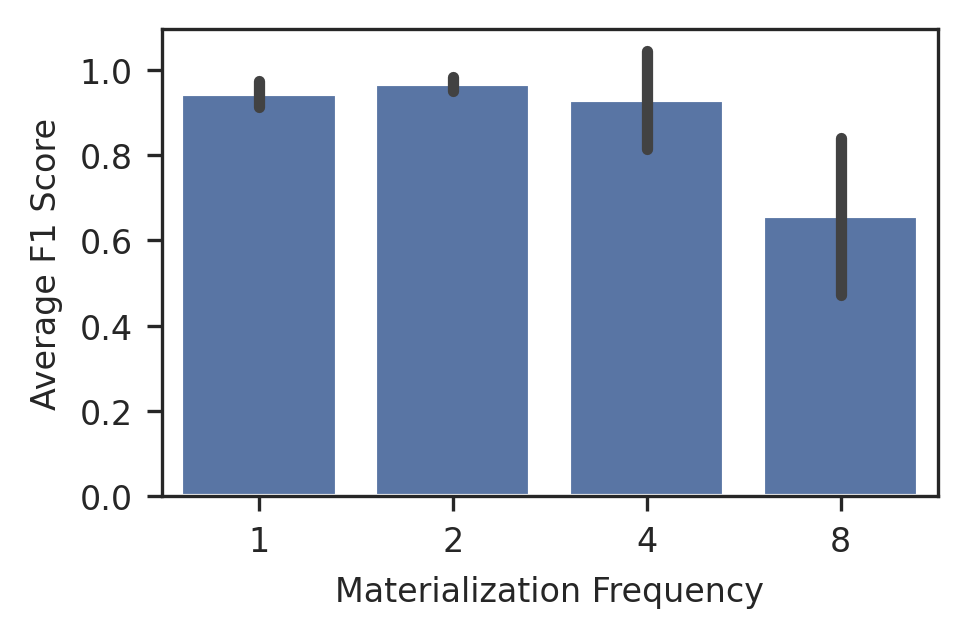

In [903]:
fig = plt.figure(figsize=set_size(column_width), dpi=300)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)
chart = sns.barplot(x=ex4_df.matfreq, y='F1', data=ex4_df, ci='sd', color='#4c72b0')
plt.xlabel('Materialization Frequency')
plt.ylabel('Average F1 Score')

fig.savefig('matfreq.pdf', format='pdf', bbox_inches='tight')

# Debug Area 

In [187]:
nb = '20210126-153738'
filename='pc2cell-test+group+join+pivot_relic_result.csv'
r_df = pd.read_csv(RESULT_DIR+'/'+nb+'/'+filename, index_col=0)
r_df

,nb_name,rows,columns,artifacts,index,numclusters,distance_metric,edges_correct,edges_missing,edges_to_remove,join_edges,precision,recall,F1,missing_files,time,pre_cluster,stage_name
0,20210126-153738,100,10,20,False,NaN,pc2cell-test+group+join+pivot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.032478,PC2,load
1,20210126-153738,100,10,20,False,NaN,pc2cell-test+group+join+pivot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.258313,PC2,cell_pair_compute
2,20210126-153738,100,10,20,False,11.0,pc2cell-test+group+join+pivot,7.0,12.0,1.0,NaN,0.875000,0.368421,0.518519,0.0,1.265602,PC2,1_intra
3,20210126-153738,100,10,20,False,11.0,pc2cell-test+group+join+pivot,7.0,12.0,1.0,NaN,0.875000,0.368421,0.518519,0.0,1.272678,PC2,1_intra2
4,20210126-153738,100,10,20,False,11.0,pc2cell-test+group+join+pivot,9.0,10.0,1.0,NaN,0.900000,0.473684,0.620690,0.0,6.726090,PC2,2_join
5,20210126-153738,100,10,20,False,11.0,pc2cell-test+group+join+pivot,11.0,8.0,1.0,NaN,0.916667,0.578947,0.709677,0.0,6.734407,PC2,2_join
6,20210126-153738,100,10,20,False,11.0,pc2cell-test+group+join+pivot,13.0,6.0,1.0,NaN,0.928571,0.684211,0.787879,0.0,6.766329,PC2,2_join
7,20210126-153738,100,10,20,False,11.0,pc2cell-test+group+join+pivot,13.0,6.0,1.0,NaN,0.928571,0.684211,0.787879,0.0,6.773984,PC2,2_join
8,20210126-153738,100,10,20,False,11.0,pc2cell-test+group+join+pivot,14.0,5.0,1.0,NaN,0.933333,0.736842,0.823529,0.0,6.819644,PC2,3_inter
9,20210126-153738,100,10,20,False,11.0,pc2cell-test+group+join+pivot,15.0,4.0,1.0,NaN,0.937500,0.789474,0.857143,0.0,6.827560,PC2,3_inter


In [200]:
[print(x) for x in agg_df5.groupby(['artifacts3']).first().reset_index().nb.values]

20210126-153738
20210126-160643
20210126-153808
20210126-160727
20210126-153850
20210126-160825
20210126-155221
20210126-164315
20210126-154016
20210126-161841
20210126-170807
20210126-181326
20210126-171012
20210126-181616
20210126-171319
20210126-182026
20210126-174626
20210126-190421
20210126-171907
20210126-183004


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]